# EDO: End-to-End Differentiable Optimizer

MIE1666 Fall 2023 Group 10

Codebase consulted:

Original S2V-DQN
https://github.com/Hanjun-Dai/graph_comb_opt.git

S2V-DQN (Pytorch versions)
COLGE, no TSP, structure not fully correct..
https://github.com/louisv123/COLGE.git

Again a Pytorch version, but with modified details
https://github.com/DavidLee-4032/Graph_Opt

Pytorch version, w.r.t 95% percent of the original S2V-DQN
https://medium.com/unit8-machine-learning-publication/routing-traveling-salesmen-on-random-graphs-using-reinforcement-learning-in-pytorch-7378e4814980

PyEPO for predict then optimize setups and baselines:
https://github.com/khalil-research/PyEPO

"Attention, Learn to Solve Routing Problems!" codebase
https://github.com/wouterkool/attention-learn-to-route


# MIE1666 Group 10 - EDO, on TSP10 with noise

In this notebook, we implement a reinforcement learning approach to the traveling salesman problem. It is based on Q-learning and structure2vec graph embeddings. Further more we fit S2V-DQN into the predict then optimize framework to obtain a end-to-end differentiable pipeline.

TSP10 with noise is from PyEPO setup, where we quote:

"PyEPO generates costs from a distance matrix. The distance is the sum of two parts: one comes from Euclidean distance, and the other is derived from a polynomial function of the features. For Euclidean distance, we create coordinates from the mixture of Gaussian distribution N (0, I) and uniform distribution U (−2, 2)."

To match the noise free TSP10 which used raw coordinates as features (2x10)and the PyEPO settings, we use 5 features:
 1. In PyEPO, those 5 features will be appended after 20 coords, making 25 features for each graph.
 2. In S2V-DQN setting because it requires features per node, the 5 features will be append to coords (2) on each node. So the shape would be (10,7).

**A major difference** between noise version and the noise free TSP10 is that, TSP10 noise uses only 1 set of coordinates, and focus on variation of noises. While noise free TSP10 generates different set of coordinates each time.

With that said, TSP10 noise presents a more constrainted simlilarity betweem tasks.

1. TSP10 noise: instances share the same coordinates, varies on noise, very similar distribution.
2. TSP10 noise free: instances only share the same unit space and uniform sampling, somewhat similar distribution.

**Seed paper S2V-DQN**

Khalil, E., Dai, H., Zhang, Y., Dilkina, B., & Song, L. (2017). Learning combinatorial optimization algorithms over graphs. Advances in neural information processing systems, 30.

(https://arxiv.org/abs/1704.01665)

PyEPO:

Tang, B., & Khalil, E. B. (2022). PyEPO: A PyTorch-based end-to-end predict-then-optimize library for linear and integer programming. arXiv preprint arXiv:2206.14234.

In [ ]:

import math
from collections import namedtuple
import os
import time

from scipy.spatial import distance_matrix
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors
from scipy.sparse import csr_matrix
from scipy.sparse.csgraph import connected_components

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from scipy.signal import medfilt

""" Note: the code is not optimized for GPU
"""
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cuda')

In [ ]:
# TSP 10
# Can't reproduce S2V-DQN numbers on TSP20, maybe more iterations or magic seeds

# Here using hyparameters from S2V-DQN, but on TSP10

SEED = 42  # A seed for the random number generator

# Graph
NR_NODES = 10  # Number of nodes N
EMBEDDING_DIMENSIONS = 64  # Embedding dimension D
EMBEDDING_ITERATIONS_T = 4  # Number of embedding iterations T

# Learning
#NR_EPISODES = 4001
NR_EPISODES = 1000
# Figure D.2 -> can show converging around 1000

MEMORY_CAPACITY = 10000
N_STEP_QL = 1  # Number of steps (n) in n-step Q-learning to wait before computing target reward estimate
BATCH_SIZE = 64

GAMMA = 0.9
INIT_LR = 5e-3
LR_DECAY_RATE = 1. - 2e-5  # learning rate decay

MIN_EPSILON = 0.1
EPSILON_DECAY_RATE = 6e-4  # epsilon decay

FOLDER_NAME = './TSP10_noise_models'  # where to checkpoint the best models

In [ ]:
# set random seed
import random
random.seed(SEED)
import numpy as np
np.random.seed(SEED)
import torch
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)

## Create Graph Instances
Below we implement a small method to generate random graph instances.

In [ ]:
# WE WILL USE a modified PyEPO GENERATOR
# UNIFORM (-2,2) to (0,10)

# To match PyEPO settings, we use 5 features:
# 1. In PyEPO, those 5 features will be appended after 20 coords
# 2. In S2V-DQN setting because it requires feats per node, the 5 features will be append to coords (2) on each node.

def dist_to_triangle(W_np):
  num_nodes = W_np.shape[0]
  # dist_matrix to PyEPO cost (triangle)
  c=np.zeros(NR_NODES*(NR_NODES-1)//2)
  l = 0
  for j in range(num_nodes):
    for k in range(j + 1, num_nodes):
      c[l] = W_np[j, k]
      l += 1

  return c

def triangle_to_dist(W_np, num_nodes=NR_NODES):
  # PyEPO cost (triangle) to dist_matrix
  c=np.zeros( (NR_NODES,NR_NODES) )
  l = 0
  for j in range(num_nodes):
    for k in range(j+1, num_nodes):
      #c[l] = W_np[j, k]
      c[k, j] = W_np[l]
      c[j, k] = W_np[l]
      l += 1

  return c

#!/usr/bin/env python
# coding: utf-8
"""
Synthetic data for traveling salesman problem
"""

import numpy as np
from scipy.spatial import distance


def TSP10_genData(num_data, num_features=20, num_nodes=10, deg=1, noise_width=0, seed=135):
    """
    A function to generate synthetic data and features for travelling salesman

    Args:
        num_data (int): number of data points
        num_features (int): dimension of features
        num_nodes (int): number of nodes
        deg (int): data polynomial degree
        noise_width (float): half witdth of data random noise
        seed (int): random seed

    Returns:
        tuple: data features (np.ndarray), costs (np.ndarray)
    """
    # positive integer parameter
    if type(deg) is not int:
        raise ValueError("deg = {} should be int.".format(deg))
    if deg <= 0:
        raise ValueError("deg = {} should be positive.".format(deg))
    # set seed
    rnd = np.random.RandomState(seed)
    # number of data points
    n = num_data
    # dimension of features
    p = num_features
    # number of nodes
    m = num_nodes
    # random coordinates
    # UNIFORM(0,10) + NORMAL（0,1）
    coords = np.concatenate((rnd.uniform(0, 10, (m // 2, 2)),
                             rnd.normal(0, 1, (m - m // 2, 2))))
    #print("coords")
    #print(coords.shape)
    #print(coords)
    #print(coords.flatten())

    # distance matrix
    org_dist = distance.cdist(coords, coords, "euclidean")
    # random matrix parameter B
    B = rnd.binomial(1, 0.5, (m * (m - 1) // 2, p)) * rnd.uniform(
        -2, 2, (m * (m - 1) // 2, p))
    # feature vectors
    x_feats = rnd.normal(0, 1, (n, p))
    #print("x_feats",x_feats)
    x = np.zeros((n, num_nodes*2 + p))
    # init cost
    c = np.zeros((n, m * (m - 1) // 2))
    d_mat = np.zeros((n, m, m))
    n_coords = np.zeros((n, m, 2 + p))
    for i in range(n):
        # reshape to tri-angle
        l = 0
        for j in range(m):
            for k in range(j + 1, m):
                c[i, l] = org_dist[j, k]
                l += 1
        # noise
        noise = rnd.uniform(1 - noise_width, 1 + noise_width,
                                  m * (m - 1) // 2)
        # from feature to edge
        c[i] += (((np.dot(B, x_feats[i].reshape(p, 1)).T / np.sqrt(p) + 3)
                  ** deg) / 3 ** (deg - 1)).reshape(-1) * noise
        x[i] = np.concatenate((coords.flatten(),x_feats[i]))
        d_mat[i] = triangle_to_dist(c[i])
        n_coords[i] = np.concatenate((coords,np.tile(x_feats[i], (num_nodes, 1))),axis=1)

    # rounding
    x = np.around(x, decimals=4)
    c = np.around(c, decimals=4)
    d_mat = np.around(d_mat, decimals=4)
    n_coords = np.around(n_coords, decimals=4)
    #n_coords

    return x, c, n_coords, d_mat

feats, costs, coords, d_matrix = TSP10_genData(num_data=NR_EPISODES, num_features=5, num_nodes=NR_NODES, deg=1, noise_width=0, seed=SEED)

print(feats.shape)
print(costs.shape)
print(coords.shape)
print(d_matrix.shape)
print(feats[0])
print(costs[0])
print(coords[0])
print(d_matrix[0])



(1000, 25)
(1000, 45)
(1000, 10, 7)
(1000, 10, 10)
[ 3.7454  9.5071  7.3199  5.9866  1.5602  1.5599  0.5808  8.6618  6.0112
  7.0807 -0.4695  0.5426 -0.4634 -0.4657  0.242  -1.9133 -1.7249 -0.5623
 -1.0128  0.3142  0.2241  0.0126  0.0977 -0.773   0.0245]
[ 8.3014 11.3002  6.0477  6.3202 12.4751 13.9921 14.5228 14.4594 14.0177
 10.2977 10.8023  4.0486 12.4848 12.9262 13.4339 14.1692 13.0343  9.9744
 10.1128  5.0969  5.8789  6.7036  6.9305  6.0766  8.6347 11.2746 12.1575
 13.6637 11.7059 10.8748 12.2394 12.9506 13.7679 14.0481 12.7009  3.6985
  5.4865  4.4231  3.6452  4.0145  4.2678  3.884   5.9025  5.7221  4.9517]
[[ 3.7454  9.5071  0.2241  0.0126  0.0977 -0.773   0.0245]
 [ 7.3199  5.9866  0.2241  0.0126  0.0977 -0.773   0.0245]
 [ 1.5602  1.5599  0.2241  0.0126  0.0977 -0.773   0.0245]
 [ 0.5808  8.6618  0.2241  0.0126  0.0977 -0.773   0.0245]
 [ 6.0112  7.0807  0.2241  0.0126  0.0977 -0.773   0.0245]
 [-0.4695  0.5426  0.2241  0.0126  0.0977 -0.773   0.0245]
 [-0.4634 -0.4657  0.2241

In [ ]:
# TSP20 - 10^6
# TSP10 - 10


def get_graph_mat(n=10, size=10):
    """ Throws n nodes uniformly at random on a square, and build a (fully connected) graph.
        Returns the (N, 2) coordinates matrix, and the (N, N) matrix containing pairwise euclidean distances.
    """
    coords = size * np.random.uniform(size=(n,2))
    dist_mat = distance_matrix(coords, coords)
    return coords, dist_mat

def plot_graph(coords, mat):
    """ Utility function to plot the fully connected graph
    """
    n = len(coords)

    plt.scatter(coords[:,0], coords[:,1], s=[50 for _ in range(n)])
    for i in range(n):
        for j in range(n):
            if j < i:
                plt.plot([coords[i,0], coords[j,0]], [coords[i,1], coords[j,1]], 'b', alpha=0.7)

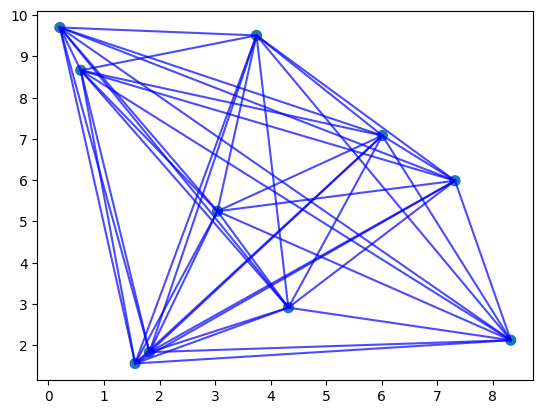

In [ ]:
coords, W_np = get_graph_mat(n=10)
plot_graph(coords, W_np)

In [ ]:
coords

array([[3.74540119, 9.50714306],
       [7.31993942, 5.98658484],
       [1.5601864 , 1.5599452 ],
       [0.58083612, 8.66176146],
       [6.01115012, 7.08072578],
       [0.20584494, 9.69909852],
       [8.32442641, 2.12339111],
       [1.81824967, 1.8340451 ],
       [3.04242243, 5.24756432],
       [4.31945019, 2.9122914 ]])

In [ ]:
W_np.shape

(10, 10)

## Define the state
We now define the state tuple, containing a graph (given by a weights matrix `W`), the noode coordinates `coords` and the partial solution (list of visited nodes).
We also define the function `state2tens`, which translates such tuples into tensors (partially loosing the sequence order information).

Further from S2V-DQN, we include features.

In [ ]:
State = namedtuple('State', ('W', 'coords', 'partial_solution'))

def state2tens(state):
    """ Creates a Pytorch tensor representing the history of visited nodes, from a (single) state tuple.

        Returns a (Nx5) tensor, where for each node we store whether this node is in the sequence,
        whether it is first or last, and its (x,y) coordinates.
    """
    solution = set(state.partial_solution)
    sol_last_node = state.partial_solution[-1] if len(state.partial_solution) > 0 else -1
    sol_first_node = state.partial_solution[0] if len(state.partial_solution) > 0 else -1
    coords = state.coords
    nr_nodes = coords.shape[0]

    xv = [[(1 if i in solution else 0),
           (1 if i == sol_first_node else 0),
           (1 if i == sol_last_node else 0),
           coords[i,0],
           coords[i,1],
           coords[i,2],
           coords[i,3],
           coords[i,4],
           coords[i,5],
           coords[i,6]
          ] for i in range(nr_nodes)]

    return torch.tensor(xv, dtype=torch.float32, requires_grad=False, device=device)

## The Q-Function
Below, we write the neural network that will parameterize the function Q(s, a).

In [ ]:
class QNet(nn.Module):
    """ The neural net that will parameterize the function Q(s, a)

        The input is the state (containing the graph and visited nodes),
        and the output is a vector of size N containing Q(s, a) for each of the N actions a.
    """

    def __init__(self, emb_dim, T=4):
        """ emb_dim: embedding dimension p
            T: number of iterations for the graph embedding
        """
        super(QNet, self).__init__()
        self.emb_dim = emb_dim
        self.T = T

        # We use 5 dimensions for representing the nodes' states:
        # * A binary variable indicating whether the node has been visited
        # * A binary variable indicating whether the node is the first of the visited sequence
        # * A binary variable indicating whether the node is the last of the visited sequence
        # * The (x, y) coordinates of the node.
        # * +5 features
        #self.node_dim = 5
        self.node_dim = 10

        # We can have an extra layer after theta_1 (for the sake of example to make the network deeper)
        nr_extra_layers_1 = 1

        # Build the learnable affine maps:
        self.theta1 = nn.Linear(self.node_dim, self.emb_dim, True)
        self.theta2 = nn.Linear(self.emb_dim, self.emb_dim, True)
        self.theta3 = nn.Linear(self.emb_dim, self.emb_dim, True)
        self.theta4 = nn.Linear(1, self.emb_dim, True)
        self.theta5 = nn.Linear(2*self.emb_dim, 1, True)
        self.theta6 = nn.Linear(self.emb_dim, self.emb_dim, True)
        self.theta7 = nn.Linear(self.emb_dim, self.emb_dim, True)

        # Small note: your self.theta1_extras (line 35 in the QNet codeblock in the article) will not receive gradient updates when defined in this way.
        #self.theta1_extras = [nn.Linear(self.emb_dim, self.emb_dim, True) for _ in range(nr_extra_layers_1)]
        # Need to wrap in nn.ModuleList()
        self.theta1_extras = nn.ModuleList([nn.Linear(self.emb_dim, self.emb_dim, True) for _ in range(nr_extra_layers_1)])

    def forward(self, xv, Ws):
        # xv: The node features (batch_size, num_nodes, node_dim)
        # Ws: The graphs (batch_size, num_nodes, num_nodes)

        num_nodes = xv.shape[1]
        batch_size = xv.shape[0]

        # pre-compute 1-0 connection matrices masks (batch_size, num_nodes, num_nodes)
        conn_matrices = torch.where(Ws > 0, torch.ones_like(Ws), torch.zeros_like(Ws)).to(device)

        # Graph embedding
        # Note: we first compute s1 and s3 once, as they are not dependent on mu
        mu = torch.zeros(batch_size, num_nodes, self.emb_dim, device=device)
        s1 = self.theta1(xv)  # (batch_size, num_nodes, emb_dim)
        for layer in self.theta1_extras:
            s1 = layer(F.relu(s1))  # we apply the extra layer

        s3_1 = F.relu(self.theta4(Ws.unsqueeze(3)))  # (batch_size, nr_nodes, nr_nodes, emb_dim) - each "weigth" is a p-dim vector
        s3_2 = torch.sum(s3_1, dim=1)  # (batch_size, nr_nodes, emb_dim) - the embedding for each node
        s3 = self.theta3(s3_2)  # (batch_size, nr_nodes, emb_dim)

        for t in range(self.T):
            s2 = self.theta2(conn_matrices.matmul(mu))
            mu = F.relu(s1 + s2 + s3)

        """ prediction
        """
        # we repeat the global state (summed over nodes) for each node,
        # in order to concatenate it to local states later
        global_state = self.theta6(torch.sum(mu, dim=1, keepdim=True).repeat(1, num_nodes, 1))

        local_action = self.theta7(mu)  # (batch_dim, nr_nodes, emb_dim)

        out = F.relu(torch.cat([global_state, local_action], dim=2))
        return self.theta5(out).squeeze(dim=2)

In [ ]:
""" See what the model returns
"""
model = QNet(3, T=1).to(device)
#coords, W_np = get_graph_mat(n=10)
n_coords, n_costs, n_coords, n_W_np = TSP10_genData(num_data=10)
coords=n_coords[0]
W_np=n_W_np[0]
W = torch.tensor(W_np, dtype=torch.float32, device=device)
xv = torch.rand((1, W.shape[0], 10)).to(device) # random node state
print(xv.shape)
Ws = W.unsqueeze(0)

y = model(xv, Ws)
print('model output: {}'.format(y))

torch.Size([1, 10, 10])
model output: tensor([[-13.3001, -13.2558, -13.1176, -12.9081, -13.0212, -13.6890, -13.6778,
         -13.6212, -13.7027, -13.6800]], device='cuda:0',
       grad_fn=<SqueezeBackward1>)


### A wrapper around the neural net
Below, we define the class `QFunction`, which will act as a wrapper around the neural net `QNet`, and can manipulate TSP (partial) solutions and translate them to tensors.

In [ ]:
class QFunction():
    def __init__(self, model, optimizer, lr_scheduler, name=""):
        self.model = model  # The actual QNet
        self.optimizer = optimizer
        self.lr_scheduler = lr_scheduler
        self.loss_fn = nn.MSELoss()
        self.name = name

    def predict(self, state_tsr, W):
        # batch of 1 - only called at inference time
        with torch.no_grad():
            estimated_rewards = self.model(state_tsr.unsqueeze(0), W.unsqueeze(0))
        return estimated_rewards[0]

    def get_best_action(self, state_tsr, state):
        """ Computes the best (greedy) action to take from a given state
            Returns a tuple containing the ID of the next node and the corresponding estimated reward
        """
        W = state.W
        estimated_rewards = self.predict(state_tsr, W)  # size (nr_nodes,)
        sorted_reward_idx = estimated_rewards.argsort(descending=True)

        solution = state.partial_solution

        already_in = set(solution)
        for idx in sorted_reward_idx.tolist():
            # Can reach node, and node is not already visited
            if (len(solution) == 0 or W[solution[-1], idx] > 0) and idx not in already_in:
                return idx, estimated_rewards[idx].item()

    def batch_update(self, states_tsrs, Ws, actions, targets):
        """ Take a gradient step using the loss computed on a batch of (states, Ws, actions, targets)

            states_tsrs: list of (single) state tensors
            Ws: list of W tensors
            actions: list of actions taken
            targets: list of targets (resulting estimated rewards after taking the actions)
        """
        Ws_tsr = torch.stack(Ws).to(device)
        xv = torch.stack(states_tsrs).to(device)
        self.optimizer.zero_grad()

        # the rewards estimated by Q for the given actions
        estimated_rewards = self.model(xv, Ws_tsr)[range(len(actions)), actions]

        loss = self.loss_fn(estimated_rewards, torch.tensor(targets, device=device))
        loss_val = loss.item()

        loss.backward()
        self.optimizer.step()
        self.lr_scheduler.step()

        return loss_val

## Define experiences & memory
We'll now a tuple representing an experience, and the memory that contains such experiences.
An experience is composed of a (state, action) tuple, and the corresponding "next state" and reward. The "next state" can be N step after the "state" in the case of N-step Q-learning. In experiences, we save states both in their tuple and tensor representations, in order to avoid computing these somewhat expensive translations after the experience has been stored.

The `Memory` class implements a memory of limited size.

In [ ]:
# Note: we store state tensors in experience to compute these tensors only once later on
Experience = namedtuple('Experience', ('state', 'state_tsr', 'action', 'reward', 'next_state', 'next_state_tsr'))

class Memory(object):
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0
        self.nr_inserts = 0

    def remember(self, experience):
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = experience
        self.position = (self.position + 1) % self.capacity
        self.nr_inserts += 1

    def sample_batch(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return min(self.nr_inserts, self.capacity)

## Other useful things
Below, we'll write a few more helper functions for computing solution length, deciding if a state is final and getting a next node at random from the graph.

In [ ]:
def total_distance(solution, W):
    if len(solution) < 2:
        return 0  # there is no travel

    total_dist = 0
    for i in range(len(solution) - 1):
        total_dist += W[solution[i], solution[i+1]].item()

    # if this solution is "complete", go back to initial point
    if len(solution) == W.shape[0]:
        total_dist += W[solution[-1], solution[0]].item()

    return total_dist

def is_state_final(state):
    return len(set(state.partial_solution)) == state.W.shape[0]

def get_next_neighbor_random(state):
    solution, W = state.partial_solution, state.W

    if len(solution) == 0:
        return random.choice(range(W.shape[0]))
    already_in = set(solution)
    candidates = list(filter(lambda n: n.item() not in already_in, W[solution[-1]].nonzero()))
    if len(candidates) == 0:
        return None
    return random.choice(candidates).item()

## Training Code
### Generating training set


In [ ]:

def dist_to_triangle(W_np):
  num_nodes = W_np.shape[0]
  # dist_matrix to PyEPO cost (triangle)
  c=np.zeros(NR_NODES*(NR_NODES-1)//2)
  l = 0
  for j in range(num_nodes):
    for k in range(j + 1, num_nodes):
      c[l] = W_np[j, k]
      l += 1

  return c


In [ ]:
# Pre-generate training set

train_feats=[]
train_costs=[]
train_coords=[]
train_Ws=[]

# Different sets
np.random.seed(SEED)

"""
for sample in range(NR_EPISODES):
    coords, W_np = get_graph_mat(n=NR_NODES)
    #W = torch.tensor(W_np, dtype=torch.float32, requires_grad=False, device=device)

    features = coords.reshape(1,NR_NODES*2)
    tri_cost=dist_to_triangle(W_np)

    train_coords.append(coords)
    train_Ws.append(W_np)
    train_feats.append(features[0])
    train_costs.append(tri_cost)
"""

train_feats, train_costs, train_coords, train_Ws = TSP10_genData(num_data=NR_EPISODES, num_features=5, num_nodes=NR_NODES, deg=1, noise_width=0, seed=SEED)
print(np.array(train_feats).shape)
print(np.array(train_costs).shape)
print(np.array(train_coords).shape)  # Note that for this setting, all coords are the same -> should make our model so much easier... but the tour plot will not be accurate.
print(np.array(train_Ws).shape)

(1000, 25)
(1000, 45)
(1000, 10, 7)
(1000, 10, 10)


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#!mkdir -p /content/drive/MyDrive/MASc_MIE/Courses/MIE1666/Project/submit/data/TSP10_noise

In [ ]:

import pickle
train_set = [ train_feats, train_costs, train_coords, train_Ws ]
with open('TSP10_noise_train_set_1218.pkl', 'wb') as f:
    pickle.dump(train_set, f)


In [ ]:
!cp /content/TSP10_noise_train_set_1218.pkl /content/drive/MyDrive/MASc_MIE/Courses/MIE1666/Project/submit/data/TSP10_noise

In [ ]:
#!cp /content/drive/MyDrive/MASc_MIE/Courses/MIE1666/Project/submit/data/TSP10_noise/TSP10_noise_train_set_1218.pkl  /content/

In [ ]:
"""
import pickle

with open('TSP10_noise_train_set_1218.pkl', 'rb') as handle:
    train_set = pickle.load(handle)

[ train_feats, train_costs, train_coords, train_Ws ] = train_set
print(np.array(train_feats).shape)
print(np.array(train_costs).shape)
print(np.array(train_coords).shape)
print(np.array(train_Ws).shape)
"""

(1000, 25)
(1000, 45)
(1000, 10, 7)
(1000, 10, 10)


### Model Initialization & checkpointing
We will save our best models over the course of training - here we just define two functions for loading and checkpointing models

In [ ]:
def init_model(fname=None):
    """ Create a new model. If fname is defined, load the model from the specified file.
    """
    Q_net = QNet(EMBEDDING_DIMENSIONS, T=EMBEDDING_ITERATIONS_T).to(device)
    optimizer = optim.Adam(Q_net.parameters(), lr=INIT_LR)
    lr_scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=LR_DECAY_RATE)

    if fname is not None:
        checkpoint = torch.load(fname)
        Q_net.load_state_dict(checkpoint['model'])
        optimizer.load_state_dict(checkpoint['optimizer'])
        lr_scheduler.load_state_dict(checkpoint['lr_scheduler'])

    Q_func = QFunction(Q_net, optimizer, lr_scheduler, fname)
    return Q_func, Q_net, optimizer, lr_scheduler

def checkpoint_model(model, optimizer, lr_scheduler, loss,
                     episode, avg_length, model_type="original"):
    if not os.path.exists(FOLDER_NAME):
        os.makedirs(FOLDER_NAME)

    fname = os.path.join(FOLDER_NAME, 'ep_{}'.format(episode))
    fname += '_length_{}'.format(avg_length)
    fname += '_type_{}'.format(model_type)
    fname += '.tar'

    torch.save({
        'episode': episode,
        'model': model.state_dict(),
        'optimizer': optimizer.state_dict(),
        'lr_scheduler': lr_scheduler.state_dict(),
        'loss': loss,
        'avg_length': avg_length
    }, fname)

## Test  train

In [ ]:
# seed everything for reproducible results first:
torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

# Create module, optimizer, LR scheduler, and Q-function
Q_func, Q_net, optimizer, lr_scheduler = init_model()

# Create memory
memory = Memory(MEMORY_CAPACITY)

# Storing metrics about training:
found_solutions = dict()  # episode --> (coords, W, solution)
losses = []
path_lengths = []

# keep track of median path length for model checkpointing
current_min_med_length = float('inf')

for episode in range(1):
    # sample a new random graph
    #coords, W_np = get_graph_mat(n=NR_NODES)
    coords = train_coords[episode]
    W_np = train_Ws[episode]
    W = torch.tensor(W_np, dtype=torch.float32, requires_grad=False, device=device)

    # current partial solution - a list of node index
    # start at random node i
    solution = [random.randint(0, NR_NODES-1)]
    print("solution",solution)

    # current state (tuple and tensor)
    current_state = State(partial_solution=solution, W=W, coords=coords)
    current_state_tsr = state2tens(current_state)
    print("current_state",current_state)
    print("coords",coords)
    print("current_state_tsr",current_state_tsr)

    # Keep track of some variables for insertion in replay memory:
    states = [current_state]
    states_tsrs = [current_state_tsr]  # we also keep the state tensors here (for efficiency)
    rewards = []
    actions = []

    # current value of epsilon
    epsilon = max(MIN_EPSILON, (1-EPSILON_DECAY_RATE)**episode)

    nr_explores = 0
    t = -1
    while not is_state_final(current_state):
        t += 1  # time step of this episode

        if epsilon >= random.random():
            # explore
            next_node = get_next_neighbor_random(current_state)
            nr_explores += 1
        else:
            # exploit
            next_node, est_reward = Q_func.get_best_action(current_state_tsr, current_state)
            if episode % 50 == 0:
                print('Ep {} | current sol: {} / next est reward: {}'.format(episode, solution, est_reward))

        next_solution = solution + [next_node]

        # reward observed for taking this step
        reward = -(total_distance(next_solution, W) - total_distance(solution, W))

        next_state = State(partial_solution=next_solution, W=W, coords=coords)
        next_state_tsr = state2tens(next_state)

        # store rewards and states obtained along this episode:
        states.append(next_state)
        states_tsrs.append(next_state_tsr)
        rewards.append(reward)
        actions.append(next_node)

        # store our experience in memory, using n-step Q-learning:
        if len(solution) >= N_STEP_QL:
            memory.remember(Experience(state=states[-N_STEP_QL],
                                       state_tsr=states_tsrs[-N_STEP_QL],
                                       action=actions[-N_STEP_QL],
                                       reward=sum(rewards[-N_STEP_QL:]),
                                       next_state=next_state,
                                       next_state_tsr=next_state_tsr))

        if is_state_final(next_state):
            for n in range(1, N_STEP_QL):
                memory.remember(Experience(state=states[-n],
                                           state_tsr=states_tsrs[-n],
                                           action=actions[-n],
                                           reward=sum(rewards[-n:]),
                                           next_state=next_state,
                                           next_state_tsr=next_state_tsr))

        # update state and current solution
        current_state = next_state
        current_state_tsr = next_state_tsr
        solution = next_solution

        # take a gradient step
        loss = None
        if len(memory) >= BATCH_SIZE and len(memory) >= 2000:
            experiences = memory.sample_batch(BATCH_SIZE)

            batch_states_tsrs = [e.state_tsr for e in experiences]
            batch_Ws = [e.state.W for e in experiences]
            batch_actions = [e.action for e in experiences]
            batch_targets = []

            for i, experience in enumerate(experiences):
                target = experience.reward
                if not is_state_final(experience.next_state):
                    _, best_reward = Q_func.get_best_action(experience.next_state_tsr,
                                                            experience.next_state)
                    target += GAMMA * best_reward
                batch_targets.append(target)

            # print('batch targets: {}'.format(batch_targets))
            loss = Q_func.batch_update(batch_states_tsrs, batch_Ws, batch_actions, batch_targets)
            losses.append(loss)

            """ Save model when we reach a new low average path length
            """
            med_length = np.median(path_lengths[-100:])
            if med_length < current_min_med_length:
                current_min_med_length = med_length
                checkpoint_model(Q_net, optimizer, lr_scheduler, loss, episode, med_length)

    length = total_distance(solution, W)
    path_lengths.append(length)

    if episode % 10 == 0:
        print('Ep %d. Loss = %.3f / median length = %.3f / last = %.4f / epsilon = %.4f / lr = %.4f' % (
            episode, (-1 if loss is None else loss), np.median(path_lengths[-50:]), length, epsilon,
            Q_func.optimizer.param_groups[0]['lr']))
        found_solutions[episode] = (W.clone(), coords.copy(), [n for n in solution])


# TSP20_1e6 ~25min
# TSP10_1e1 ~25min

solution [1]
current_state State(W=tensor([[ 0.0000,  8.3014, 11.3002,  6.0477,  6.3202, 12.4751, 13.9921, 14.5228,
         14.4594, 14.0177],
        [ 8.3014,  0.0000, 10.2977, 10.8023,  4.0486, 12.4848, 12.9262, 13.4339,
         14.1692, 13.0343],
        [11.3002, 10.2977,  0.0000,  9.9744, 10.1128,  5.0969,  5.8789,  6.7036,
          6.9305,  6.0766],
        [ 6.0477, 10.8023,  9.9744,  0.0000,  8.6347, 11.2746, 12.1575, 13.6637,
         11.7059, 10.8748],
        [ 6.3202,  4.0486, 10.1128,  8.6347,  0.0000, 12.2394, 12.9506, 13.7679,
         14.0481, 12.7009],
        [12.4751, 12.4848,  5.0969, 11.2746, 12.2394,  0.0000,  3.6985,  5.4865,
          4.4231,  3.6452],
        [13.9921, 12.9262,  5.8789, 12.1575, 12.9506,  3.6985,  0.0000,  4.0145,
          4.2678,  3.8840],
        [14.5228, 13.4339,  6.7036, 13.6637, 13.7679,  5.4865,  4.0145,  0.0000,
          5.9025,  5.7221],
        [14.4594, 14.1692,  6.9305, 11.7059, 14.0481,  4.4231,  4.2678,  5.9025,
          0.

## Training Loop (Original S2V-DQN with True costs)

The code below is slightly more complex than the version appearing in the Medium. Notably, here in several places we maintain states represented both as tuples and tensors. We cache the tensor versions in order to avoid re-computing them many times. Also different from the article, the version below implements a version of n-step Q-learning, it checkpoints the best models (according to the median path length), and prints some information.

In [ ]:
# seed everything for reproducible results first:
torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

# Create module, optimizer, LR scheduler, and Q-function
Q_func, Q_net, optimizer, lr_scheduler = init_model()

# Create memory
memory = Memory(MEMORY_CAPACITY)

# Storing metrics about training:
found_solutions = dict()  # episode --> (coords, W, solution)
losses = []
path_lengths = []

# keep track of median path length for model checkpointing
current_min_med_length = float('inf')

for episode in range(NR_EPISODES):
    # sample a new random graph
    #coords, W_np = get_graph_mat(n=NR_NODES)
    coords = train_coords[episode]
    W_np = train_Ws[episode]
    W = torch.tensor(W_np, dtype=torch.float32, requires_grad=False, device=device)

    # current partial solution - a list of node index
    # start at random node i
    solution = [random.randint(0, NR_NODES-1)]

    # current state (tuple and tensor)
    current_state = State(partial_solution=solution, W=W, coords=coords)
    current_state_tsr = state2tens(current_state)

    # Keep track of some variables for insertion in replay memory:
    states = [current_state]
    states_tsrs = [current_state_tsr]  # we also keep the state tensors here (for efficiency)
    rewards = []
    actions = []

    # current value of epsilon
    epsilon = max(MIN_EPSILON, (1-EPSILON_DECAY_RATE)**episode)

    nr_explores = 0
    t = -1
    while not is_state_final(current_state):
        t += 1  # time step of this episode

        if epsilon >= random.random():
            # explore
            next_node = get_next_neighbor_random(current_state)
            nr_explores += 1
        else:
            # exploit
            next_node, est_reward = Q_func.get_best_action(current_state_tsr, current_state)
            if episode % 50 == 0:
                print('Ep {} | current sol: {} / next est reward: {}'.format(episode, solution, est_reward))

        next_solution = solution + [next_node]

        # reward observed for taking this step
        reward = -(total_distance(next_solution, W) - total_distance(solution, W))

        next_state = State(partial_solution=next_solution, W=W, coords=coords)
        next_state_tsr = state2tens(next_state)

        # store rewards and states obtained along this episode:
        states.append(next_state)
        states_tsrs.append(next_state_tsr)
        rewards.append(reward)
        actions.append(next_node)

        # store our experience in memory, using n-step Q-learning:
        if len(solution) >= N_STEP_QL:
            memory.remember(Experience(state=states[-N_STEP_QL],
                                       state_tsr=states_tsrs[-N_STEP_QL],
                                       action=actions[-N_STEP_QL],
                                       reward=sum(rewards[-N_STEP_QL:]),
                                       next_state=next_state,
                                       next_state_tsr=next_state_tsr))

        if is_state_final(next_state):
            for n in range(1, N_STEP_QL):
                memory.remember(Experience(state=states[-n],
                                           state_tsr=states_tsrs[-n],
                                           action=actions[-n],
                                           reward=sum(rewards[-n:]),
                                           next_state=next_state,
                                           next_state_tsr=next_state_tsr))

        # update state and current solution
        current_state = next_state
        current_state_tsr = next_state_tsr
        solution = next_solution

        # take a gradient step
        loss = None
        if len(memory) >= BATCH_SIZE and len(memory) >= 2000:
            experiences = memory.sample_batch(BATCH_SIZE)

            batch_states_tsrs = [e.state_tsr for e in experiences]
            batch_Ws = [e.state.W for e in experiences]
            batch_actions = [e.action for e in experiences]
            batch_targets = []

            for i, experience in enumerate(experiences):
                target = experience.reward
                if not is_state_final(experience.next_state):
                    _, best_reward = Q_func.get_best_action(experience.next_state_tsr,
                                                            experience.next_state)
                    target += GAMMA * best_reward
                batch_targets.append(target)

            # print('batch targets: {}'.format(batch_targets))
            loss = Q_func.batch_update(batch_states_tsrs, batch_Ws, batch_actions, batch_targets)
            losses.append(loss)

            """ Save model when we reach a new low average path length
            """
            med_length = np.median(path_lengths[-100:])
            if med_length < current_min_med_length:
                current_min_med_length = med_length
                checkpoint_model(Q_net, optimizer, lr_scheduler, loss, episode, med_length)

    length = total_distance(solution, W)
    path_lengths.append(length)

    if episode % 10 == 0:
        print('Ep %d. Loss = %.3f / median length = %.3f / last = %.4f / epsilon = %.4f / lr = %.4f' % (
            episode, (-1 if loss is None else loss), np.median(path_lengths[-50:]), length, epsilon,
            Q_func.optimizer.param_groups[0]['lr']))
        found_solutions[episode] = (W.clone(), coords.copy(), [n for n in solution])


# TSP20_1e6 ~25min
# TSP10_1e1 ~25min

Ep 0. Loss = -1.000 / median length = 93.630 / last = 93.6301 / epsilon = 1.0000 / lr = 0.0050
Ep 10. Loss = -1.000 / median length = 93.630 / last = 98.0057 / epsilon = 0.9940 / lr = 0.0050
Ep 20. Loss = -1.000 / median length = 90.349 / last = 93.2648 / epsilon = 0.9881 / lr = 0.0050
Ep 30. Loss = -1.000 / median length = 90.992 / last = 81.6060 / epsilon = 0.9822 / lr = 0.0050
Ep 40. Loss = -1.000 / median length = 90.402 / last = 111.9045 / epsilon = 0.9763 / lr = 0.0050
Ep 50. Loss = -1.000 / median length = 91.243 / last = 93.4540 / epsilon = 0.9704 / lr = 0.0050
Ep 60. Loss = -1.000 / median length = 92.910 / last = 75.3903 / epsilon = 0.9646 / lr = 0.0050
Ep 70. Loss = -1.000 / median length = 93.868 / last = 100.5960 / epsilon = 0.9589 / lr = 0.0050
Ep 80. Loss = -1.000 / median length = 95.241 / last = 104.0699 / epsilon = 0.9531 / lr = 0.0050
Ep 90. Loss = -1.000 / median length = 98.012 / last = 104.8365 / epsilon = 0.9474 / lr = 0.0050
Ep 100 | current sol: [7, 2, 3, 6, 5]

## Inspect Training Metrics
Let's look at the (moving averages of) loss and path length over training.

Text(0.5, 0, 'episode')

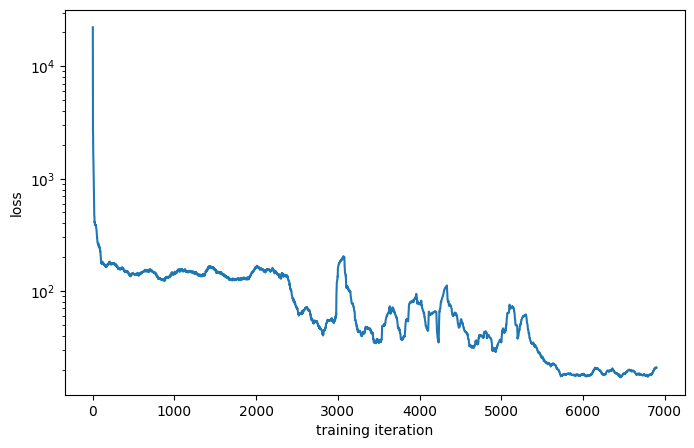

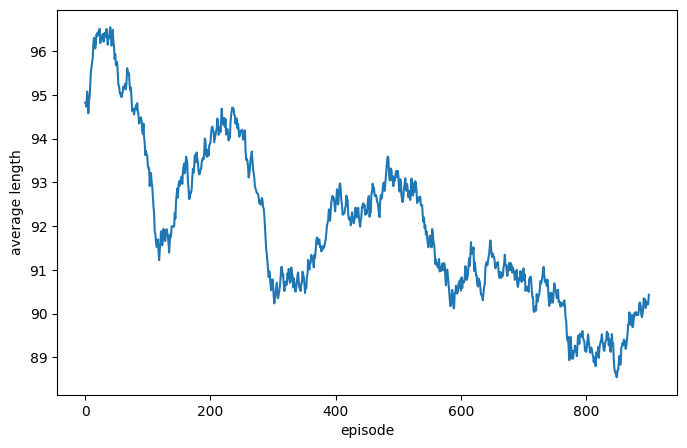

In [ ]:
def _moving_avg(x, N=10):
    return np.convolve(np.array(x), np.ones((N,))/N, mode='valid')

plt.figure(figsize=(8,5))
plt.semilogy(_moving_avg(losses, 100))
plt.ylabel('loss')
plt.xlabel('training iteration')

plt.figure(figsize=(8,5))
plt.plot(_moving_avg(path_lengths, 100))
plt.ylabel('average length')
plt.xlabel('episode')

## Re-run Best Model and Look at Paths

### Exact solvers from PyEPO

In [ ]:
# Exact solutions
# download
!git clone -b main --depth 1 https://github.com/khalil-research/PyEPO.git
# install
!pip install PyEPO/pkg/.

Cloning into 'PyEPO'...
remote: Enumerating objects: 126, done.
remote: Counting objects: 100% (126/126), done.
remote: Compressing objects: 100% (111/111), done.
remote: Total 126 (delta 22), reused 65 (delta 12), pack-reused 0
Receiving objects: 100% (126/126), 2.44 MiB | 15.52 MiB/s, done.
Resolving deltas: 100% (22/22), done.
Processing ./PyEPO/pkg
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.1/82.1 kB 1.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.5/12.5 MB 61.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.4/13.4 MB 50.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 kB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.8/56.8 kB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 14.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 17.2 MB/s eta 0:00:00
  Created wheel for pyepo: filename=

In [ ]:
import pyepo
from pyepo.model.opt import optModel
from collections import defaultdict

tru_optmodel = pyepo.model.grb.tsp.tspMTZModel(NR_NODES)
# Exact solver

train_dataset_expert = pyepo.data.dataset.optDataset(tru_optmodel, train_feats, train_costs)
#~ 11min, A100 Colab

Auto-Sklearn cannot be imported.
Restricted license - for non-production use only - expires 2025-11-24
Optimizing for optDataset...


100%|██████████| 1000/1000 [01:31<00:00, 10.87it/s]


In [ ]:
import pickle
train_dataset_expert_sols = [train_dataset_expert.sols, train_dataset_expert.objs]
with open('TSP10_noise_1218_train_dataset_expert_sols.pkl', 'wb') as f:
    pickle.dump(train_dataset_expert_sols, f)

In [ ]:
!cp /content/TSP10_noise_1218_train_dataset_expert_sols.pkl /content/drive/MyDrive/MASc_MIE/Courses/MIE1666/Project/submit/data/TSP10_noise/

In [ ]:
"""
!cp /content/drive/MyDrive/MASc_MIE/Courses/MIE1666/Project/submit/data/TSP10_noise/TSP10_noise_1218_train_dataset_expert_sols.pkl /content/

with open('TSP10_noise_1218_train_dataset_expert_sols.pkl', 'rb') as handle:
    train_dataset_expert_sols = pickle.load(handle)

"""

## Plot functions

In [ ]:
def _moving_avg(x, N=10):
    return np.convolve(np.array(x), np.ones((N,))/N, mode='valid')

def dist_to_triangle(W_np):
  num_nodes = W_np.shape[0]
  # dist_matrix to PyEPO cost (triangle)
  c=np.zeros(NR_NODES*(NR_NODES-1)//2)
  l = 0
  for j in range(num_nodes):
    for k in range(j + 1, num_nodes):
      c[l] = W_np[j, k]
      l += 1

  return c



""" A function to plot solutions
"""
def plot_solution(coords, mat, solution):
    plt.scatter(coords[:,0], coords[:,1])
    n = len(coords)

    for idx in range(n-1):
        i, next_i = solution[idx], solution[idx+1]
        plt.plot([coords[i, 0], coords[next_i, 0]], [coords[i, 1], coords[next_i, 1]], 'k', lw=2, alpha=0.8)

    i, next_i = solution[-1], solution[0]
    plt.plot([coords[i, 0], coords[next_i, 0]], [coords[i, 1], coords[next_i, 1]], 'k', lw=2, alpha=0.8)
    plt.plot(coords[solution[0], 0], coords[solution[0], 1], 'x', markersize=10)


# solutions = [true, model, random]
def plot_solutions(coords, mat, solutions):
  fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15,4))
  #for solution in solutions:
  idx=0
  obj_values = []
  for solution, ax in zip(solutions, axes.flatten()):
    colors = []
    for i in range(len(solution)):
      if i == solution[0]:
        colors.append('red')
      else:
        colors.append('blue')

    ax.scatter(coords[:,0], coords[:,1], color=colors)
    n = len(coords)

    X = coords[solution, 0]
    Y = coords[solution, 1]
    ax.plot(X, Y,"--")

    model_str = ["solver", "RL", "random"]
    obj_value = total_distance(solution, mat)
    ax.title.set_text(model_str[idx]+' / len = {}'.format(obj_value))
    obj_values.append(obj_value)
    idx+=1

  return obj_values

def getTour(optmodel, sol):
    """
    A method to get a tour from solution

    Args:
        sol (list): solution

    Returns:
        list: a TSP tour
    """
    # active edges
    edges = defaultdict(list)
    for i, (j, k) in enumerate(optmodel.edges):
        #print((j, k))
        if sol[i] > 1e-2:
            edges[j].append(k)
            edges[k].append(j)

    #print(edges)
    # get tour
    visited = {list(edges.keys())[0]}
    #print(visited)
    tour = [list(edges.keys())[0]]
    #print(tour)
    while len(visited) < len(edges):
        i = tour[-1]
        for j in edges[i]:
            # FIFO here?
            if j not in visited:
                tour.append(j)
                visited.add(j)
                break
    if 0 in edges[tour[-1]]:
        tour.append(0)
    return tour

def getTourSol(sol):
    """
    A method to get a tour from solution

    Args:
        sol (list): solution

    Returns:
        list: a TSP tour
    """
    # active edges
    edges = defaultdict(list)
    for i, (j, k) in enumerate(20):
        #print((j, k))
        if sol[i] > 1e-2:
            edges[j].append(k)
            edges[k].append(j)

    #print(edges)
    # get tour
    visited = {list(edges.keys())[0]}
    #print(visited)
    tour = [list(edges.keys())[0]]
    #print(tour)
    while len(visited) < len(edges):
        i = tour[-1]
        for j in edges[i]:
            # FIFO here?
            if j not in visited:
                tour.append(j)
                visited.add(j)
                break
    if 0 in edges[tour[-1]]:
        tour.append(0)
    return tour


def print_instance(i):
    print("tru obj",dataset_expert.objs[i])
    print(np.dot(dataset_expert.sols[i],dataset_expert.costs[i]))
    #print("regret obj",np.dot(heuristic_dataset_test.sols[i],dataset_test.costs[i]))

    print(dataset_expert.sols[i])

    tru_tour = getTour(tru_optmodel,dataset_expert.sols[i])
    print(tru_tour)
    print(len(tru_tour))
    return tru_tour

## Plots

In [ ]:
metrics_data={}

model_type="original"
metrics_data[model_type]={}
metrics_data[model_type]["losses"] = losses
metrics_data[model_type]["path_lengths"] = path_lengths


In [ ]:

""" Get file with smallest distance
"""
def get_best_model(model_type="original"):
  all_lengths_fnames = [f for f in os.listdir(FOLDER_NAME) if f.endswith(f'{model_type}.tar')]
  shortest_fname = sorted(all_lengths_fnames, key=lambda s: float(s.split('.tar')[0].split('_')[-3]))[0]
  print('shortest avg length found: {}'.format(shortest_fname.split('.tar')[0].split('_')[-3]))
  print('best model:',shortest_fname)

  return shortest_fname

shortest_fname = get_best_model()

shortest avg length found: 86.17620021104813
best model: ep_873_length_86.17620021104813_type_original.tar


shortest avg length found: 86.17620021104813
best model: ep_873_length_86.17620021104813_type_original.tar


,RL_ratio,random_ratio,RL_gap,random_gap
0,1.195705,1.352707,0.195705,0.352707
1,1.313908,1.282949,0.313908,0.282949
2,1.382517,1.488888,0.382517,0.488888
3,1.199254,1.393719,0.199254,0.393719
4,1.218665,1.388894,0.218665,0.388894


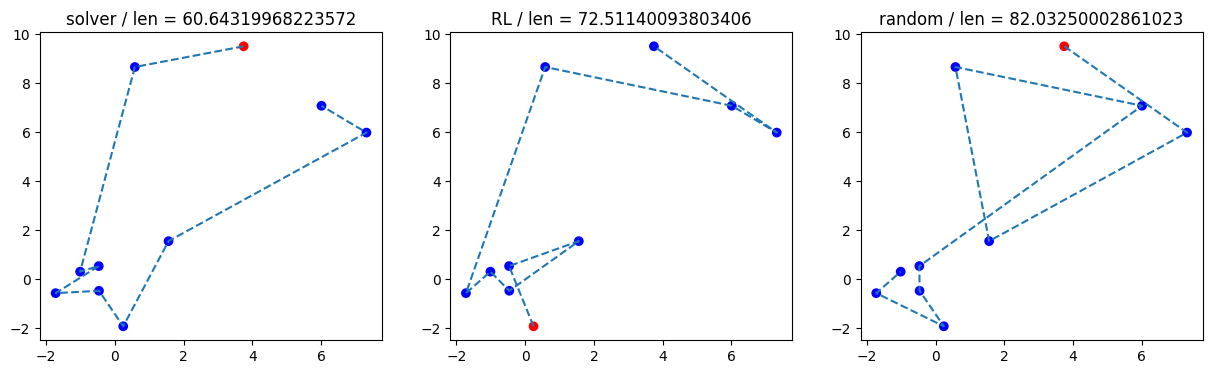

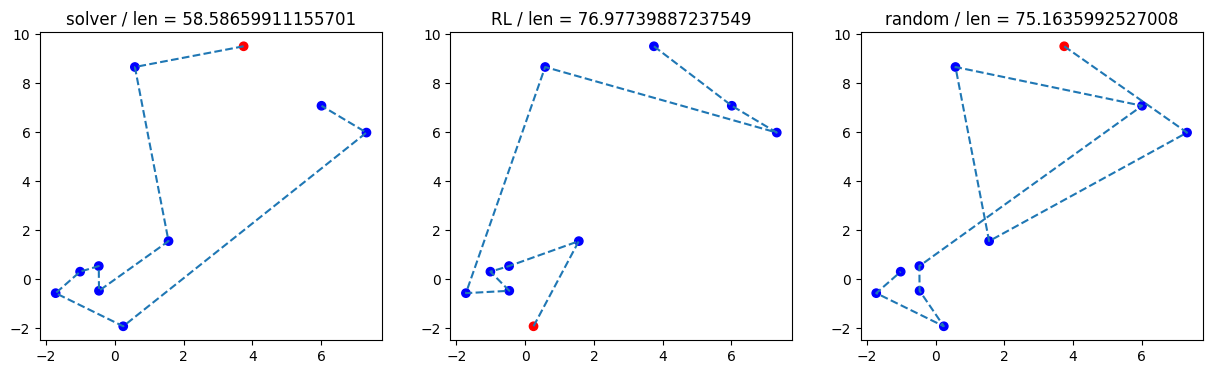

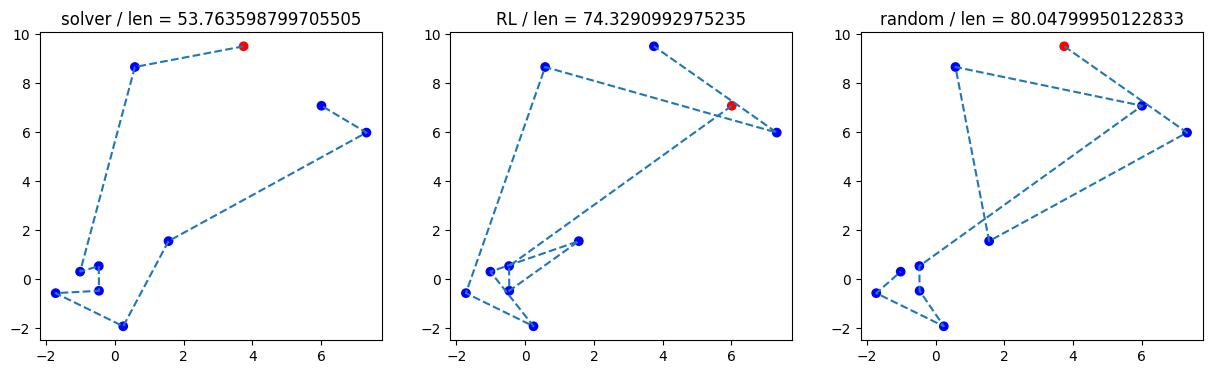

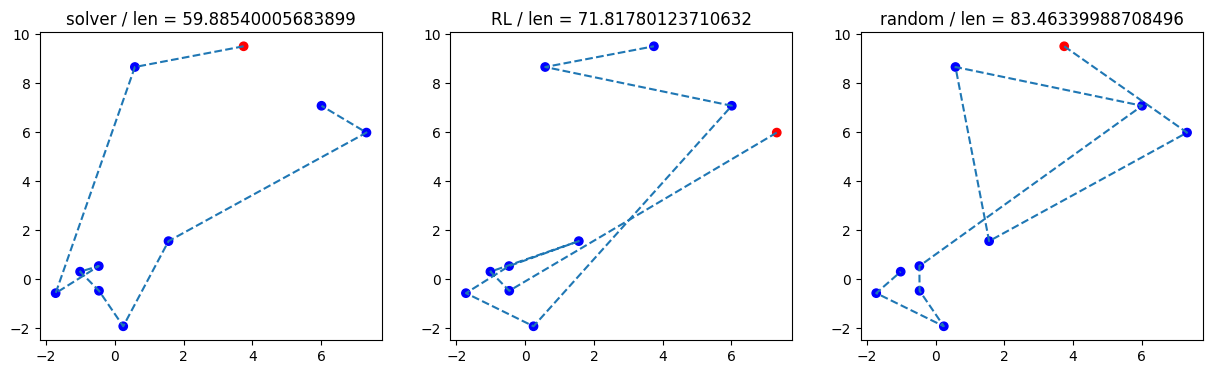

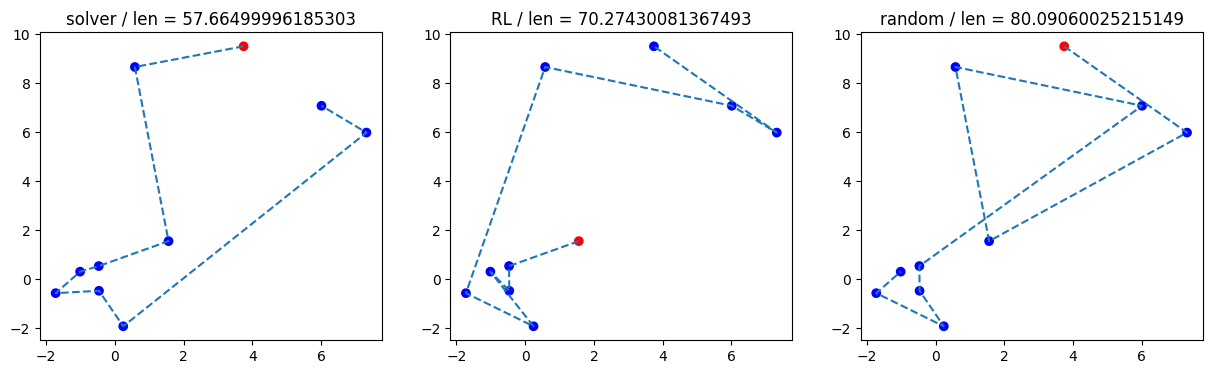

In [ ]:
""" Get file with smallest distance
"""
"""
model_type="original"
all_lengths_fnames = [f for f in os.listdir(FOLDER_NAME) if f.endswith(f'{model_type}.tar')]
shortest_fname = sorted(all_lengths_fnames, key=lambda s: float(s.split('.tar')[0].split('_')[-1]))[0]
print('shortest avg length found: {}'.format(shortest_fname.split('.tar')[0].split('_')[-1]))
"""

shortest_fname = get_best_model()

""" Load checkpoint
"""
Q_func, Q_net, optimizer, lr_scheduler = init_model(os.path.join(FOLDER_NAME, shortest_fname))

import pandas as pd
import pyepo
from pyepo.model.opt import optModel
from collections import defaultdict

tru_optmodel = pyepo.model.grb.tsp.tspMTZModel(NR_NODES)

""" Generate example solutions
"""
# Peak training set solutions

#NR_NODES = 10
gap_rows=[]
for sample in range(5):
    coords = train_coords[sample]
    W_np = train_Ws[sample]
    W = torch.tensor(W_np, dtype=torch.float32, requires_grad=False, device=device)

    tru_tour = getTour(tru_optmodel, train_dataset_expert.sols[sample])
    tru_tour = tru_tour[:-1]

    solution = [random.randint(0, NR_NODES-1)]
    current_state = State(partial_solution=solution, W=W, coords=coords)
    current_state_tsr = state2tens(current_state)

    while not is_state_final(current_state):
        next_node, est_reward = Q_func.get_best_action(current_state_tsr,
                                                       current_state)


        solution = solution + [next_node]
        current_state = State(partial_solution=solution, W=W, coords=coords)
        current_state_tsr = state2tens(current_state)

    random_solution = list(range(NR_NODES))
    solutions = [tru_tour,solution,random_solution]
    obj_values = plot_solutions(coords, W, solutions)

    gap_rows.append( [ obj_values[1]/obj_values[0], obj_values[2]/obj_values[0], (obj_values[1]-obj_values[0]) / obj_values[0], (obj_values[2]-obj_values[0]) / obj_values[0]] )

gap_df = pd.DataFrame(data=gap_rows, columns=['RL_ratio', 'random_ratio', 'RL_gap', 'random_gap'])
display(gap_df)


# 2-pass with history costs

## Regressors for cost

### GradientBoostingRegressor -> LinearRegression

In [ ]:
episodes=1000
hist_feats, hist_costs, hist_coords, hist_Ws = TSP10_genData(num_data=episodes, num_features=5, num_nodes=NR_NODES, deg=1, noise_width=0, seed=SEED+2)

# sklearn regressor
from sklearn.linear_model import LinearRegression
reg = LinearRegression() # linear regression

# build model
twostage_model = pyepo.twostage.sklearnPred(reg)

# training
twostage_model.fit(hist_feats, hist_costs)

# prediction
c_pred = twostage_model.predict(hist_feats)

In [ ]:
c_pred.shape

(1000, 45)

Train MSE: 1.339369306579713e-09


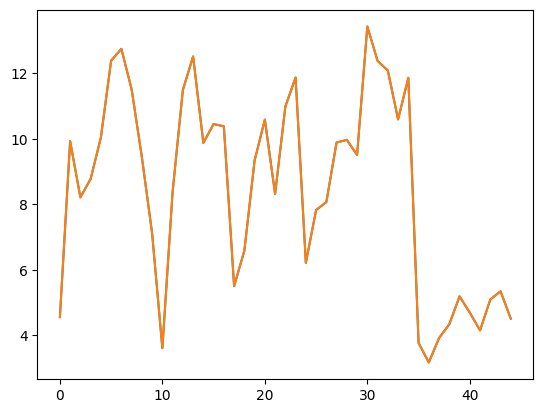

In [ ]:
from sklearn.metrics import mean_squared_error
twostage_model_MSE = mean_squared_error(c_pred, hist_costs)

print("Train MSE:",twostage_model_MSE)
plt.figure()
plt.plot(range(len(c_pred[0])), c_pred[0])
plt.plot(range(len(c_pred[0])), hist_costs[0])
plt.show()

## 2-pass: predict cost -> RL

In [ ]:
train_pred_costs = twostage_model.predict(train_feats)

train_pred_Ws = np.zeros((NR_EPISODES, NR_NODES, NR_NODES))
for i in range(len(train_pred_costs)):
  train_pred_Ws[i]=triangle_to_dist(train_pred_costs[i])

train_pred_Ws[123]

array([[ 0.        ,  4.7194866 ,  9.9325    ,  8.43094997,  9.4743748 ,
         9.90105285, 12.3911599 , 12.58720485, 11.69229539, 10.44864238],
       [ 4.7194866 ,  0.        ,  6.74449637,  5.17791442,  7.31018115,
        11.0118554 , 13.09578976, 11.2866338 , 11.49822213, 10.57172462],
       [ 9.9325    ,  6.74449637,  0.        ,  5.35443899,  5.3478906 ,
         9.6334906 , 10.62980558,  9.7679766 , 10.88989542, 10.12095349],
       [ 8.43094997,  5.17791442,  5.35443899,  0.        ,  6.32573394,
         7.68510464,  8.8302218 ,  9.83837109,  9.28444653,  8.84456979],
       [ 9.4743748 ,  7.31018115,  5.3478906 ,  6.32573394,  0.        ,
        11.90053226, 12.10889896, 11.25869109, 11.92899886, 11.36685373],
       [ 9.90105285, 11.0118554 ,  9.6334906 ,  7.68510464, 11.90053226,
         0.        ,  3.68232641,  3.29364168,  3.92060254,  3.9303782 ],
       [12.3911599 , 13.09578976, 10.62980558,  8.8302218 , 12.10889896,
         3.68232641,  0.        ,  4.577928  

In [ ]:
# seed everything for reproducible results first:
torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

# Create module, optimizer, LR scheduler, and Q-function
Q_func, Q_net, optimizer, lr_scheduler = init_model()

# Create memory
memory = Memory(MEMORY_CAPACITY)

# Storing metrics about training:
found_solutions = dict()  # episode --> (coords, W, solution)
losses = []
path_lengths = []

# keep track of median path length for model checkpointing
current_min_med_length = float('inf')

# Trial with 1000 episodes
#NR_EPISODES=1000
for episode in range(NR_EPISODES):
    # sample a new random graph
    #coords, W_np = get_graph_mat(n=NR_NODES)
    coords = train_coords[episode]
    W_np = train_Ws[episode]

    # use the 2-pass predicted weights here
    W_pred = train_pred_Ws[episode]
    W = torch.tensor(W_pred, dtype=torch.float32, requires_grad=False, device=device)

    # current partial solution - a list of node index
    # start at random node i
    solution = [random.randint(0, NR_NODES-1)]

    # current state (tuple and tensor)
    current_state = State(partial_solution=solution, W=W, coords=coords)
    current_state_tsr = state2tens(current_state)

    # Keep track of some variables for insertion in replay memory:
    states = [current_state]
    states_tsrs = [current_state_tsr]  # we also keep the state tensors here (for efficiency)
    rewards = []
    actions = []

    # current value of epsilon
    epsilon = max(MIN_EPSILON, (1-EPSILON_DECAY_RATE)**episode)

    nr_explores = 0
    t = -1
    while not is_state_final(current_state):
        t += 1  # time step of this episode

        if epsilon >= random.random():
            # explore
            next_node = get_next_neighbor_random(current_state)
            nr_explores += 1
        else:
            # exploit
            next_node, est_reward = Q_func.get_best_action(current_state_tsr, current_state)
            if episode % 50 == 0:
                print('Ep {} | current sol: {} / next est reward: {}'.format(episode, solution, est_reward))

        next_solution = solution + [next_node]

        # reward observed for taking this step
        reward = -(total_distance(next_solution, W) - total_distance(solution, W))

        next_state = State(partial_solution=next_solution, W=W, coords=coords)
        next_state_tsr = state2tens(next_state)

        # store rewards and states obtained along this episode:
        states.append(next_state)
        states_tsrs.append(next_state_tsr)
        rewards.append(reward)
        actions.append(next_node)

        # store our experience in memory, using n-step Q-learning:
        if len(solution) >= N_STEP_QL:
            memory.remember(Experience(state=states[-N_STEP_QL],
                                       state_tsr=states_tsrs[-N_STEP_QL],
                                       action=actions[-N_STEP_QL],
                                       reward=sum(rewards[-N_STEP_QL:]),
                                       next_state=next_state,
                                       next_state_tsr=next_state_tsr))

        if is_state_final(next_state):
            for n in range(1, N_STEP_QL):
                memory.remember(Experience(state=states[-n],
                                           state_tsr=states_tsrs[-n],
                                           action=actions[-n],
                                           reward=sum(rewards[-n:]),
                                           next_state=next_state,
                                           next_state_tsr=next_state_tsr))

        # update state and current solution
        current_state = next_state
        current_state_tsr = next_state_tsr
        solution = next_solution

        # take a gradient step
        loss = None
        if len(memory) >= BATCH_SIZE and len(memory) >= 2000:
            experiences = memory.sample_batch(BATCH_SIZE)

            batch_states_tsrs = [e.state_tsr for e in experiences]
            batch_Ws = [e.state.W for e in experiences]
            batch_actions = [e.action for e in experiences]
            batch_targets = []

            for i, experience in enumerate(experiences):
                target = experience.reward
                if not is_state_final(experience.next_state):
                    _, best_reward = Q_func.get_best_action(experience.next_state_tsr,
                                                            experience.next_state)
                    target += GAMMA * best_reward
                batch_targets.append(target)

            # print('batch targets: {}'.format(batch_targets))
            loss = Q_func.batch_update(batch_states_tsrs, batch_Ws, batch_actions, batch_targets)
            losses.append(loss)

            """ Save model when we reach a new low average path length
            """
            med_length = np.median(path_lengths[-100:])
            if med_length < current_min_med_length:
                current_min_med_length = med_length
                checkpoint_model(Q_net, optimizer, lr_scheduler, loss, episode, med_length, model_type="2passReg")

    length = total_distance(solution, W)
    path_lengths.append(length)

    if episode % 10 == 0:
        print('Ep %d. Loss = %.3f / median length = %.3f / last = %.4f / epsilon = %.4f / lr = %.4f' % (
            episode, (-1 if loss is None else loss), np.median(path_lengths[-50:]), length, epsilon,
            Q_func.optimizer.param_groups[0]['lr']))
        found_solutions[episode] = (W.clone(), coords.copy(), [n for n in solution])

Ep 0. Loss = -1.000 / median length = 84.433 / last = 84.4329 / epsilon = 1.0000 / lr = 0.0050
Ep 10. Loss = -1.000 / median length = 83.398 / last = 96.1903 / epsilon = 0.9940 / lr = 0.0050
Ep 20. Loss = -1.000 / median length = 82.637 / last = 82.0788 / epsilon = 0.9881 / lr = 0.0050
Ep 30. Loss = -1.000 / median length = 82.581 / last = 76.1973 / epsilon = 0.9822 / lr = 0.0050
Ep 40. Loss = -1.000 / median length = 83.398 / last = 102.3199 / epsilon = 0.9763 / lr = 0.0050
Ep 50. Loss = -1.000 / median length = 82.925 / last = 80.6892 / epsilon = 0.9704 / lr = 0.0050
Ep 60. Loss = -1.000 / median length = 83.052 / last = 78.8542 / epsilon = 0.9646 / lr = 0.0050
Ep 70. Loss = -1.000 / median length = 84.347 / last = 84.7843 / epsilon = 0.9589 / lr = 0.0050
Ep 80. Loss = -1.000 / median length = 86.609 / last = 96.2796 / epsilon = 0.9531 / lr = 0.0050
Ep 90. Loss = -1.000 / median length = 87.632 / last = 95.5257 / epsilon = 0.9474 / lr = 0.0050
Ep 100 | current sol: [7, 2, 3, 6, 5] / 

In [ ]:
model_type="2passReg"
metrics_data[model_type]={}
metrics_data[model_type]["losses"] = losses
metrics_data[model_type]["path_lengths"] = path_lengths

### Plots

Text(0.5, 0, 'episode')

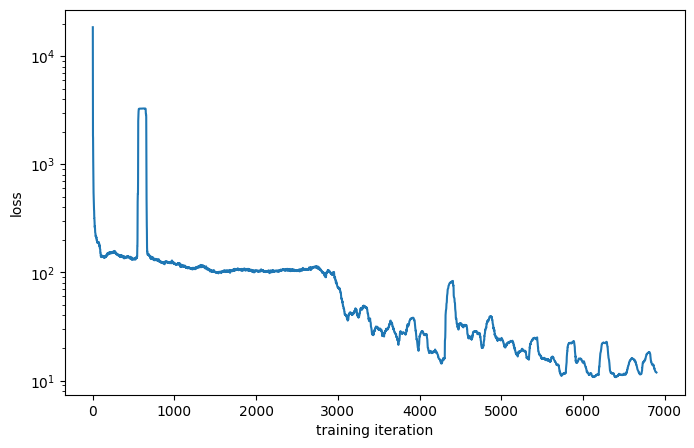

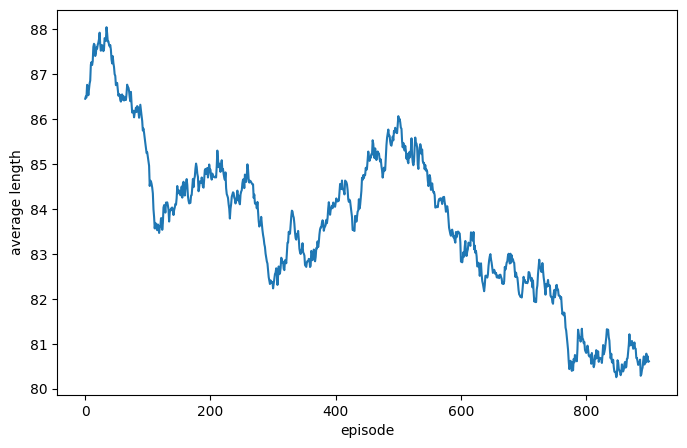

In [ ]:
model_type="2passReg"

# Plot training
plt.figure(figsize=(8,5))
plt.semilogy(_moving_avg(metrics_data[model_type]["losses"], 100))
plt.ylabel('loss')
plt.xlabel('training iteration')

plt.figure(figsize=(8,5))
plt.plot(_moving_avg(metrics_data[model_type]["path_lengths"], 100))
plt.ylabel('average length')
plt.xlabel('episode')

shortest avg length found: 78.64298105239868
best model: ep_877_length_78.64298105239868_type_2passReg.tar


,RL_ratio,random_ratio,RL_gap,random_gap
0,1.195705,1.352707,0.195705,0.352707
1,1.313908,1.282949,0.313908,0.282949
2,1.382517,1.488888,0.382517,0.488888
3,1.211207,1.393719,0.211207,0.393719
4,1.170395,1.388894,0.170395,0.388894


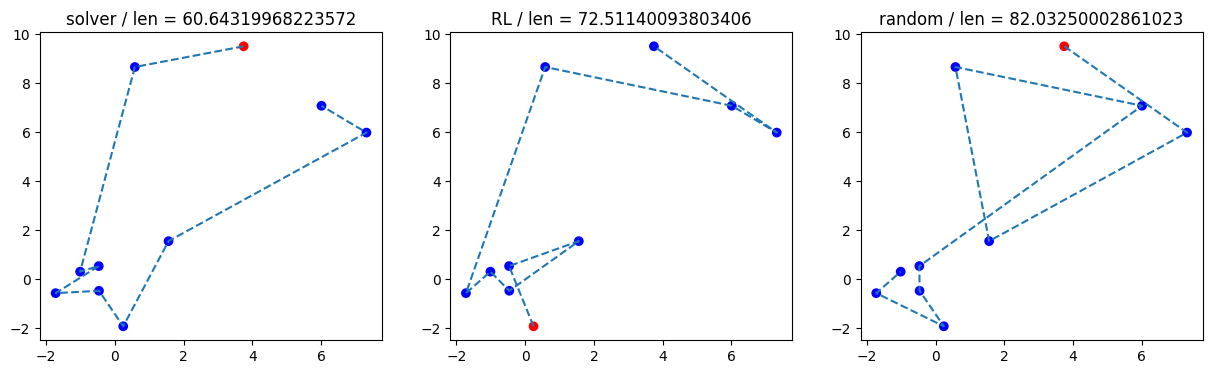

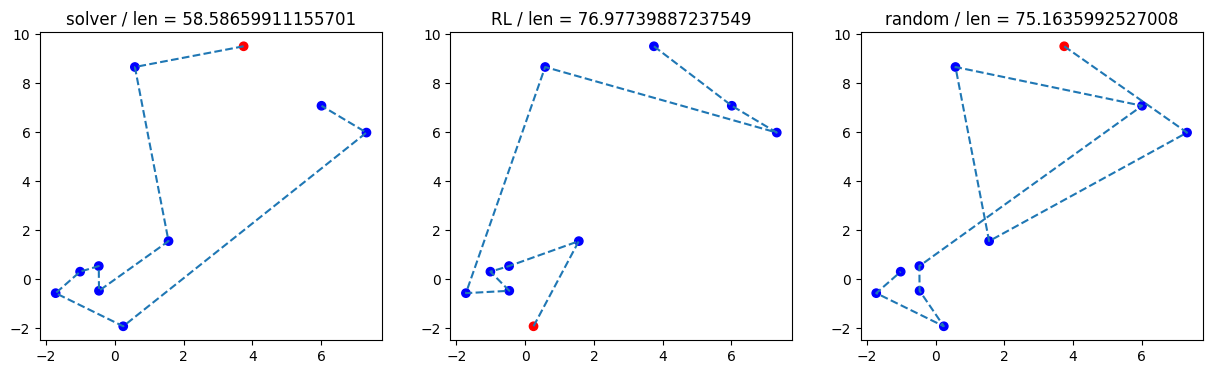

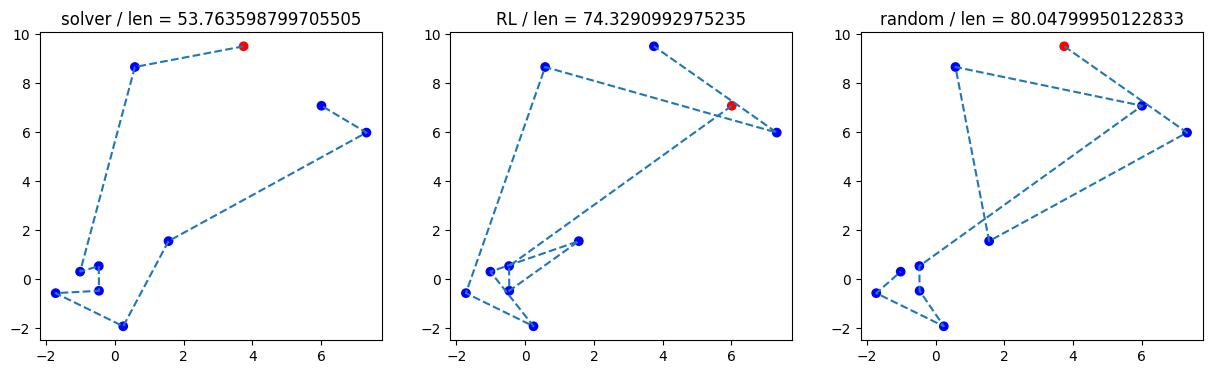

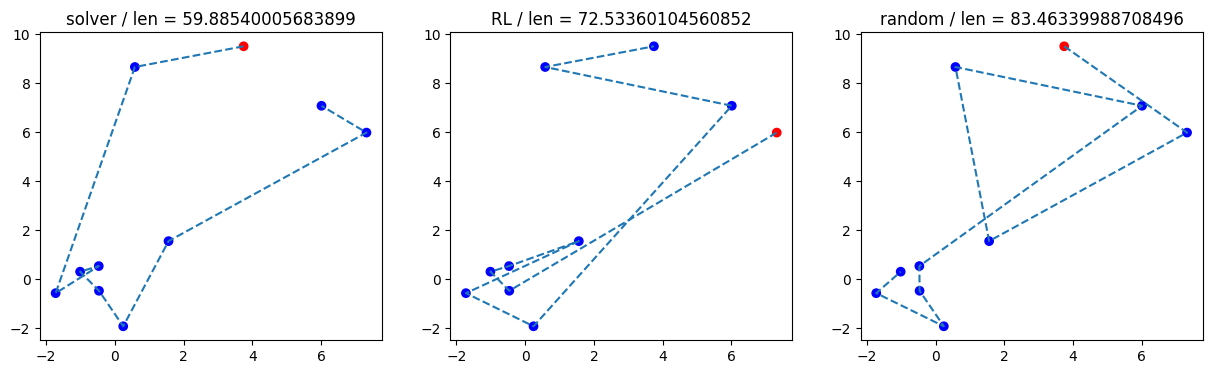

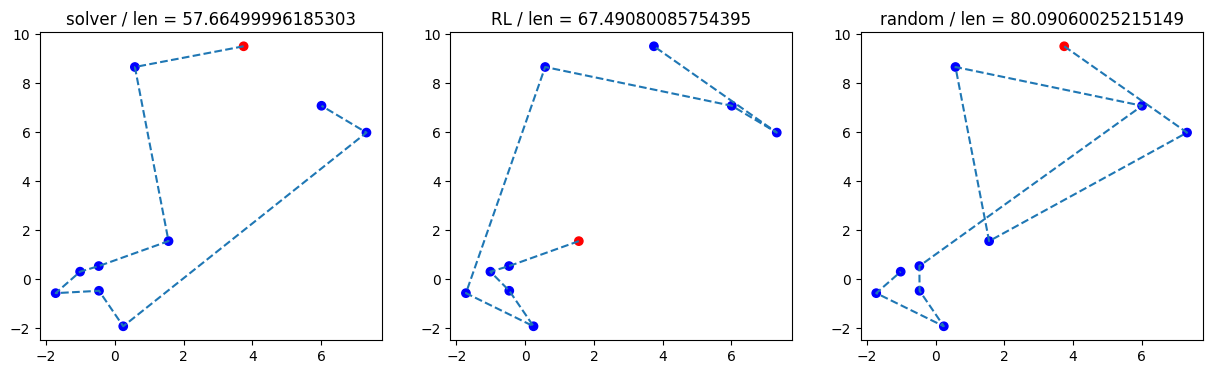

In [ ]:
""" Get file with smallest distance
"""
"""
all_lengths_fnames = [f for f in os.listdir(FOLDER_NAME) if f.endswith('.tar')]
shortest_fname = sorted(all_lengths_fnames, key=lambda s: float(s.split('.tar')[0].split('_')[-1]))[0]
print('shortest avg length found: {}'.format(shortest_fname.split('.tar')[0].split('_')[-1]))
"""

shortest_fname = get_best_model(model_type="2passReg")

""" Load checkpoint
"""
Q_func, Q_net, optimizer, lr_scheduler = init_model(os.path.join(FOLDER_NAME, shortest_fname))

import pandas as pd
import pyepo
from pyepo.model.opt import optModel
from collections import defaultdict


""" Generate example solutions
"""
#NR_NODES = 10
gap_rows=[]
for sample in range(5):
    coords = train_coords[sample]
    W_np = train_Ws[sample]
    W = torch.tensor(W_np, dtype=torch.float32, requires_grad=False, device=device)

    tru_tour = getTour(tru_optmodel, train_dataset_expert.sols[sample])
    tru_tour = tru_tour[:-1]

    solution = [random.randint(0, NR_NODES-1)]
    current_state = State(partial_solution=solution, W=W, coords=coords)
    current_state_tsr = state2tens(current_state)

    while not is_state_final(current_state):
        next_node, est_reward = Q_func.get_best_action(current_state_tsr,
                                                       current_state)


        solution = solution + [next_node]
        current_state = State(partial_solution=solution, W=W, coords=coords)
        current_state_tsr = state2tens(current_state)

    random_solution = list(range(NR_NODES))
    solutions = [tru_tour,solution,random_solution]
    obj_values = plot_solutions(coords, W, solutions)

    gap_rows.append( [ obj_values[1]/obj_values[0], obj_values[2]/obj_values[0], (obj_values[1]-obj_values[0]) / obj_values[0], (obj_values[2]-obj_values[0]) / obj_values[0]] )

gap_df = pd.DataFrame(data=gap_rows, columns=['RL_ratio', 'random_ratio', 'RL_gap', 'random_gap'])
display(gap_df)


# 1-pass with IRL (Future work)

In [ ]:
# Exact solutions
# download
!git clone -b main --depth 1 https://github.com/khalil-research/PyEPO.git
# install
!pip install PyEPO/pkg/.

Cloning into 'PyEPO'...
remote: Enumerating objects: 126, done.
remote: Counting objects: 100% (126/126), done.
remote: Compressing objects: 100% (111/111), done.
remote: Total 126 (delta 22), reused 65 (delta 12), pack-reused 0
Receiving objects: 100% (126/126), 2.44 MiB | 5.48 MiB/s, done.
Resolving deltas: 100% (22/22), done.
Processing ./PyEPO/pkg
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.1/82.1 kB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.5/12.5 MB 107.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.4/13.4 MB 111.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 kB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.8/56.8 kB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 18.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 19.4 MB/s eta 0:00:00
  Created wheel for pyepo: filename

In [ ]:
# set random seed
import random
random.seed(SEED)
import numpy as np
np.random.seed(SEED)
import torch
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)

In [ ]:
import pyepo
import random

from torch.utils.data import Dataset
import torch
import os
import pickle

from pyepo.model.opt import optModel

import math
import torch
import os
import argparse
import numpy as np
import itertools
from tqdm import tqdm
from torch.utils.data import DataLoader
import time
from datetime import timedelta

import numpy as np
import networkx as nx
from collections import defaultdict
from itertools import combinations


Auto-Sklearn cannot be imported.
Restricted license - for non-production use only - expires 2025-11-24


In [ ]:
import pyepo

# TSP 20
num_data = 500 # number of data
#num_feat = 10 # size of feature
num_feat = NR_NODES*2
num_node = NR_NODES # number of nodes
feats, costs = pyepo.data.tsp.genData(num_data+500, num_feat, num_node, deg=1, noise_width=0, seed=135)

print(feats.shape)
print(costs.shape)

(1000, 20)
(1000, 45)


In [ ]:
def dist_to_triangle(W_np):
  num_nodes = W_np.shape[0]
  # dist_matrix to PyEPO cost (triangle)
  c=np.zeros(NR_NODES*(NR_NODES-1)//2)
  l = 0
  for j in range(num_nodes):
    for k in range(j + 1, num_nodes):
      c[l] = W_np[j, k]
      l += 1

  return c

#c_test=dist_to_triangle(W_np)
#c_test

array([0.71669708, 0.47567907, 0.50313035, 0.63047243, 0.4563975 ,
       0.11641851, 0.11928073, 0.0755036 , 0.79142546, 0.38766098,
       0.6987507 , 0.46454198, 1.14761807, 0.83261507, 0.81695947,
       0.79061637, 0.82012503, 0.31278763, 0.17967472, 0.82797864,
       0.58367632, 0.5945734 , 0.53378955, 0.48975457, 0.29719418,
       0.66843191, 0.56789189, 0.60760137, 0.52202169, 0.28884095,
       0.92513491, 0.72992914, 0.74945792, 0.6795139 , 0.35593058,
       0.36066606, 0.40967645, 0.38292784, 0.9121097 , 0.06021278,
       0.0504262 , 0.85569579, 0.08829755, 0.89637084, 0.81046227])

In [ ]:
NR_EPISODES=1000

feats=np.zeros((NR_EPISODES,NR_NODES*2))
costs=np.zeros((NR_EPISODES,(NR_NODES*(NR_NODES-1)//2)))
for episode in range(NR_EPISODES):
    # sample a new random graph
    coords, W_np = get_graph_mat(n=NR_NODES)

    features = coords.reshape(1,NR_NODES*2)
    tri_cost=dist_to_triangle(W_np)

    feats[episode]=features
    costs[episode]=tri_cost

print(feats.shape)
print(costs.shape)

(1000, 20)
(1000, 45)


In [ ]:
# Exact solver
tru_optmodel = pyepo.model.grb.tsp.tspMTZModel(10)

dataset_expert = pyepo.data.dataset.optDataset(tru_optmodel, feats, costs)


Optimizing for optDataset...


100%|██████████| 1000/1000 [01:36<00:00, 10.37it/s]


In [ ]:
print(dataset_expert.feats[:2])
print(dataset_expert.costs[:2])
print(dataset_expert.sols[:2])
print(dataset_expert.objs[:2])

[[0.3006191  0.86760605 0.58370601 0.06544492 0.92077703 0.94893862
  0.24966583 0.78511311 0.6149686  0.71629642 0.09779658 0.28327349
  0.22194162 0.53295975 0.75728564 0.19238457 0.83381829 0.28611463
  0.55260173 0.56171335]
 [0.7250001  0.17497976 0.77094303 0.67405756 0.24768177 0.88049117
  0.22389418 0.50678447 0.39491749 0.42193193 0.82071046 0.45210362
  0.48883779 0.25257273 0.55249193 0.72762693 0.71305794 0.12432984
  0.72777998 0.11555473]]
[[0.85064721 0.6254685  0.09696041 0.34886991 0.61853174 0.34377069
  0.8151493  0.78894464 0.39631501 0.94560985 0.7934136  0.65160188
  0.53250095 0.59113754 0.21504316 0.33354351 0.49724222 0.69081766
  0.38424106 1.05849274 0.81327078 0.77401774 0.6685039  0.53431868
  0.3717282  0.52431601 0.25367292 0.78038773 0.76826661 0.37640087
  0.6745189  0.43368484 0.54289756 0.48265055 0.16668998 0.27884623
  0.66572263 0.73602719 0.53326962 0.63449561 0.65979207 0.33190794
  0.12100649 0.42225496 0.3937479 ]
 [0.50118798 0.85180933 0.601

In [ ]:
def getTour(optmodel, sol):
    """
    A method to get a tour from solution

    Args:
        sol (list): solution

    Returns:
        list: a TSP tour
    """
    # active edges
    edges = defaultdict(list)
    for i, (j, k) in enumerate(optmodel.edges):
        #print((j, k))
        if sol[i] > 1e-2:
            edges[j].append(k)
            edges[k].append(j)

    #print(edges)
    # get tour
    visited = {list(edges.keys())[0]}
    #print(visited)
    tour = [list(edges.keys())[0]]
    #print(tour)
    while len(visited) < len(edges):
        i = tour[-1]
        for j in edges[i]:
            # FIFO here?
            if j not in visited:
                tour.append(j)
                visited.add(j)
                break
    if 0 in edges[tour[-1]]:
        tour.append(0)
    return tour

def print_instance(i):
    print("tru obj",dataset_expert.objs[i])
    print(np.dot(dataset_expert.sols[i],dataset_expert.costs[i]))
    #print("regret obj",np.dot(heuristic_dataset_test.sols[i],dataset_test.costs[i]))

    print(dataset_expert.sols[i])

    tru_tour = getTour(tru_optmodel,dataset_expert.sols[i])
    print(tru_tour)
    print(len(tru_tour))
    return tru_tour

tru_tour = print_instance(0)

tru obj [3.06817759]
3.068177591657272
[0 1 1 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 1 0
 0 0 0 0 0 1 0 1]
[0, 2, 4, 9, 8, 7, 1, 5, 6, 3, 0]
11


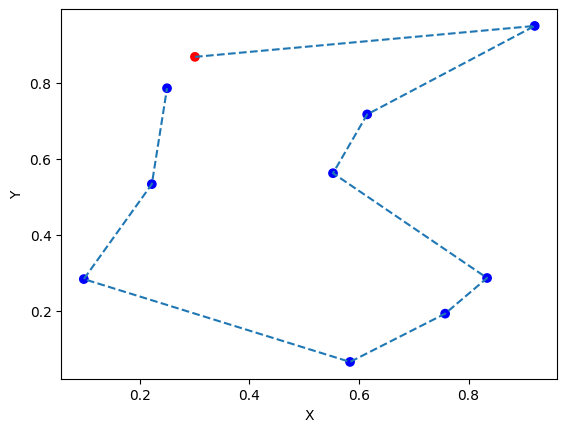

In [ ]:
#-*- coding: utf-8 -*-
import numpy as np
import matplotlib.pyplot as plt
import math
from sklearn.decomposition import PCA

def visualize_2D_trip(tours , coords): # Plot tour
  coords = coords.reshape(NR_NODES,2)
  tours = tours[:-1]
  plt.figure(1)
  colors = []
  for i in range(len(tours)):
    if i == tours[0]:
      colors.append('red')
    else:
      colors.append('blue')

  plt.scatter(coords[:,0], coords[:,1], color=colors) # Plot cities
  #tour=np.array(list(range(len(tours))) + [0]) # Plot tour
  X = coords[tours, 0]
  Y = coords[tours, 1]
  plt.plot(X, Y,"--")

  plt.xlabel('X')
  plt.ylabel('Y')
  plt.show()


visualize_2D_trip(tru_tour, coords=feats[0])

### IRL library

https://github.com/HumanCompatibleAI/imitation

In [ ]:
!pip install imitation

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 216.4/216.4 kB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 953.9/953.9 kB 23.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 181.7/181.7 kB 14.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.9/107.9 kB 12.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 409.6/409.6 kB 20.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 521.2/521.2 kB 24.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 226.8/226.8 kB 19.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.6/190.6 kB 16.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 5.5 MB/s eta 0:00:00
  Created wheel for docopt: filename=docopt-0.6.2-py2.py3-none-any.whl size=13706 sha256=1cb438645720dcb1a6172c8a94bff844fd1e90accd91e56

In [ ]:
!pip install imitation[test]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 9.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 177.5/177.5 kB 12.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 120.8/120.8 kB 11.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.1/64.1 kB 6.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 390.5/390.5 kB 14.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 138.3/138.3 kB 15.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.2/18.2 MB 40.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 64.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 298.2/298.2 kB 28.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.7/41.7 kB 4.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 33.7/33.7 MB 14.

In [ ]:
import datasets
from stable_baselines3.common.vec_env import DummyVecEnv

from imitation.data import huggingface_utils

# Download some expert trajectories from the HuggingFace Datasets Hub.
dataset = datasets.load_dataset("HumanCompatibleAI/ppo-CartPole-v1")

# Convert the dataset to a format usable by the imitation library.
expert_trajectories = huggingface_utils.TrajectoryDatasetSequence(dataset["train"])

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/100 [00:00<?, ? examples/s]

In [ ]:
from imitation.data import rollout

trajectory_stats = rollout.rollout_stats(expert_trajectories)

print(
    f"We have {trajectory_stats['n_traj']} trajectories."
    f"The average length of each trajectory is {trajectory_stats['len_mean']}."
    f"The average return of each trajectory is {trajectory_stats['return_mean']}."
)

We have 100 trajectories.The average length of each trajectory is 500.0.The average return of each trajectory is 500.0.


In [ ]:
from imitation.algorithms import sqil
import gymnasium as gym

venv = DummyVecEnv([lambda: gym.make("CartPole-v1")])
sqil_trainer = sqil.SQIL(
    venv=venv,
    demonstrations=expert_trajectories,
    policy="MlpPolicy",
)

In [ ]:
from stable_baselines3.common.evaluation import evaluate_policy

reward_before_training, _ = evaluate_policy(sqil_trainer.policy, venv, 10)
print(f"Reward before training: {reward_before_training}")

Reward before training: 11.1


/usr/local/lib/python3.10/dist-packages/stable_baselines3/common/evaluation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


In [ ]:
"""
sqil_trainer.train(
    total_timesteps=1_000_000,
)  # Note: set to 1_000_000 to obtain good results
reward_after_training, _ = evaluate_policy(sqil_trainer.policy, venv, 10)
print(f"Reward after training: {reward_after_training}")
"""

# ~21 min on CPU Colab -> Reward after training: 500.0

Reward after training: 500.0


# Try remove cost(u,v) just from emdedding

Complete remove or Set it to {0,1}

But also keep true cost in rewards

Also check if AM used cost in rewards..

## Just mask it to {0,1}, so the information of there's an edge still presents

In [ ]:
(W_np > 0.0).astype(int)

array([[0, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 0, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 0, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 0, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 0, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 0, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 0, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 0, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 0, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 0]])

In [ ]:
#NR_EPISODES= 1000

# seed everything for reproducible results first:
torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

# Create module, optimizer, LR scheduler, and Q-function
Q_func, Q_net, optimizer, lr_scheduler = init_model()

# Create memory
memory = Memory(MEMORY_CAPACITY)

# Storing metrics about training:
found_solutions = dict()  # episode --> (coords, W, solution)
losses = []
path_lengths = []

# keep track of median path length for model checkpointing
current_min_med_length = float('inf')

for episode in range(NR_EPISODES):
    # sample a new random graph
    #coords, W_np = get_graph_mat(n=NR_NODES)
    coords = train_coords[episode]
    W_np = train_Ws[episode]

    W = torch.tensor(W_np, dtype=torch.float32, requires_grad=False, device=device)
    W_np_masked = (W_np > 0.0).astype(int)
    W_masked = torch.tensor(W_np_masked, dtype=torch.float32, requires_grad=False, device=device)

    # current partial solution - a list of node index
    # start at random node i
    solution = [random.randint(0, NR_NODES-1)]

    # current state (tuple and tensor)
    current_state = State(partial_solution=solution, W=W_masked, coords=coords)
    current_state_tsr = state2tens(current_state)

    # Keep track of some variables for insertion in replay memory:
    states = [current_state]
    states_tsrs = [current_state_tsr]  # we also keep the state tensors here (for efficiency)
    rewards = []
    actions = []

    # current value of epsilon
    epsilon = max(MIN_EPSILON, (1-EPSILON_DECAY_RATE)**episode)

    nr_explores = 0
    t = -1
    while not is_state_final(current_state):
        t += 1  # time step of this episode

        if epsilon >= random.random():
            # explore
            next_node = get_next_neighbor_random(current_state)
            nr_explores += 1
        else:
            # exploit
            next_node, est_reward = Q_func.get_best_action(current_state_tsr, current_state)
            if episode % 50 == 0:
                print('Ep {} | current sol: {} / next est reward: {}'.format(episode, solution, est_reward))

        next_solution = solution + [next_node]

        # reward observed for taking this step
        reward = -(total_distance(next_solution, W) - total_distance(solution, W))

        next_state = State(partial_solution=next_solution, W=W_masked, coords=coords)
        next_state_tsr = state2tens(next_state)

        # store rewards and states obtained along this episode:
        states.append(next_state)
        states_tsrs.append(next_state_tsr)
        rewards.append(reward)
        actions.append(next_node)

        # store our experience in memory, using n-step Q-learning:
        if len(solution) >= N_STEP_QL:
            memory.remember(Experience(state=states[-N_STEP_QL],
                                       state_tsr=states_tsrs[-N_STEP_QL],
                                       action=actions[-N_STEP_QL],
                                       reward=sum(rewards[-N_STEP_QL:]),
                                       next_state=next_state,
                                       next_state_tsr=next_state_tsr))

        if is_state_final(next_state):
            for n in range(1, N_STEP_QL):
                memory.remember(Experience(state=states[-n],
                                           state_tsr=states_tsrs[-n],
                                           action=actions[-n],
                                           reward=sum(rewards[-n:]),
                                           next_state=next_state,
                                           next_state_tsr=next_state_tsr))

        # update state and current solution
        current_state = next_state
        current_state_tsr = next_state_tsr
        solution = next_solution

        # take a gradient step
        loss = None
        if len(memory) >= BATCH_SIZE and len(memory) >= 2000:
            experiences = memory.sample_batch(BATCH_SIZE)

            batch_states_tsrs = [e.state_tsr for e in experiences]
            batch_Ws = [e.state.W for e in experiences]
            batch_actions = [e.action for e in experiences]
            batch_targets = []

            for i, experience in enumerate(experiences):
                target = experience.reward
                if not is_state_final(experience.next_state):
                    _, best_reward = Q_func.get_best_action(experience.next_state_tsr,
                                                            experience.next_state)
                    target += GAMMA * best_reward
                batch_targets.append(target)

            # print('batch targets: {}'.format(batch_targets))
            loss = Q_func.batch_update(batch_states_tsrs, batch_Ws, batch_actions, batch_targets)
            losses.append(loss)

            """ Save model when we reach a new low average path length
            """
            med_length = np.median(path_lengths[-100:])
            if med_length < current_min_med_length:
                current_min_med_length = med_length
                checkpoint_model(Q_net, optimizer, lr_scheduler, loss, episode, med_length, model_type="maskEdge")

    length = total_distance(solution, W)
    path_lengths.append(length)

    if episode % 10 == 0:
        print('Ep %d. Loss = %.3f / median length = %.3f / last = %.4f / epsilon = %.4f / lr = %.4f' % (
            episode, (-1 if loss is None else loss), np.median(path_lengths[-50:]), length, epsilon,
            Q_func.optimizer.param_groups[0]['lr']))
        found_solutions[episode] = (W.clone(), coords.copy(), [n for n in solution])

Ep 0. Loss = -1.000 / median length = 93.630 / last = 93.6301 / epsilon = 1.0000 / lr = 0.0050
Ep 10. Loss = -1.000 / median length = 93.630 / last = 98.0057 / epsilon = 0.9940 / lr = 0.0050
Ep 20. Loss = -1.000 / median length = 90.349 / last = 93.2648 / epsilon = 0.9881 / lr = 0.0050
Ep 30. Loss = -1.000 / median length = 90.992 / last = 81.6060 / epsilon = 0.9822 / lr = 0.0050
Ep 40. Loss = -1.000 / median length = 90.402 / last = 111.9045 / epsilon = 0.9763 / lr = 0.0050
Ep 50. Loss = -1.000 / median length = 91.243 / last = 93.4540 / epsilon = 0.9704 / lr = 0.0050
Ep 60. Loss = -1.000 / median length = 92.910 / last = 75.3903 / epsilon = 0.9646 / lr = 0.0050
Ep 70. Loss = -1.000 / median length = 94.094 / last = 100.5960 / epsilon = 0.9589 / lr = 0.0050
Ep 80. Loss = -1.000 / median length = 95.241 / last = 104.0699 / epsilon = 0.9531 / lr = 0.0050
Ep 90. Loss = -1.000 / median length = 98.012 / last = 104.8365 / epsilon = 0.9474 / lr = 0.0050
Ep 100 | current sol: [7, 2, 3, 6, 5]

In [ ]:
model_type="maskEdge"
metrics_data[model_type]={}
metrics_data[model_type]["losses"] = losses
metrics_data[model_type]["path_lengths"] = path_lengths

### Plots

Text(0.5, 0, 'episode')

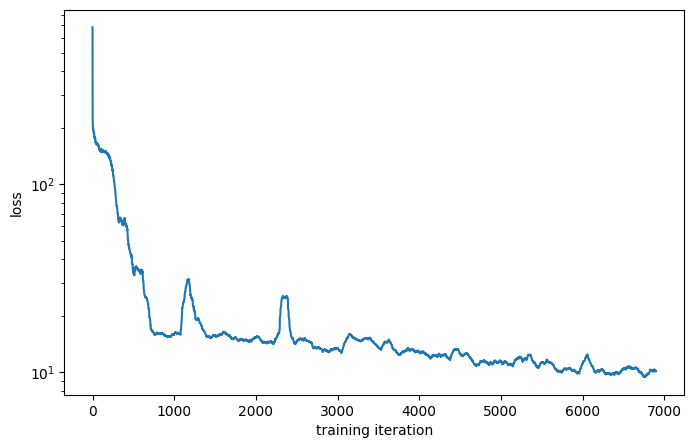

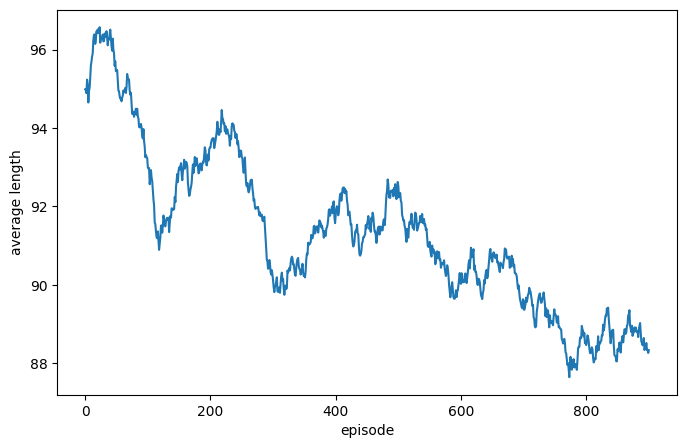

In [ ]:

plt.figure(figsize=(8,5))
plt.semilogy(_moving_avg(metrics_data[model_type]["losses"], 100))
plt.ylabel('loss')
plt.xlabel('training iteration')

plt.figure(figsize=(8,5))
plt.plot(_moving_avg(metrics_data[model_type]["path_lengths"], 100))
plt.ylabel('average length')
plt.xlabel('episode')

shortest avg length found: 85.4273499250412
best model: ep_877_length_85.4273499250412_type_maskEdge.tar


,RL_ratio,random_ratio,RL_gap,random_gap
0,1.208802,1.352707,0.208802,0.352707
1,1.345838,1.282949,0.345838,0.282949
2,1.382517,1.488888,0.382517,0.488888
3,1.211207,1.393719,0.211207,0.393719
4,1.218665,1.388894,0.218665,0.388894


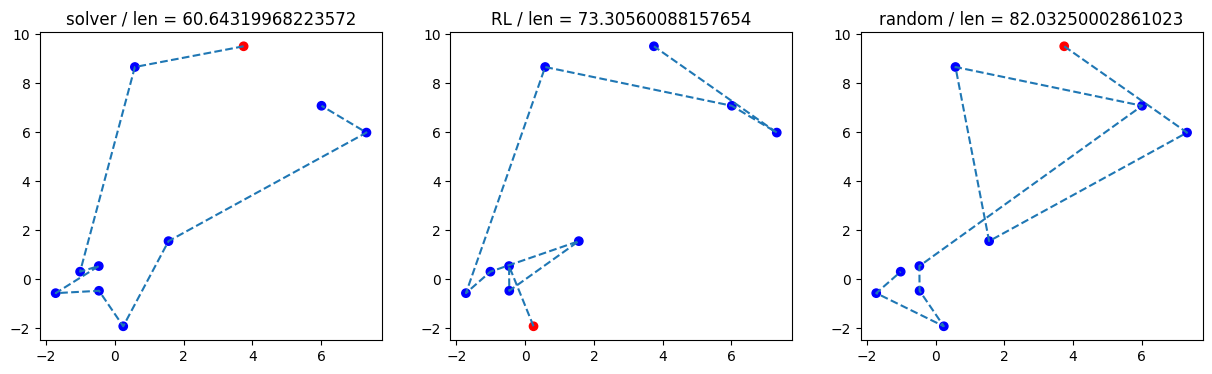

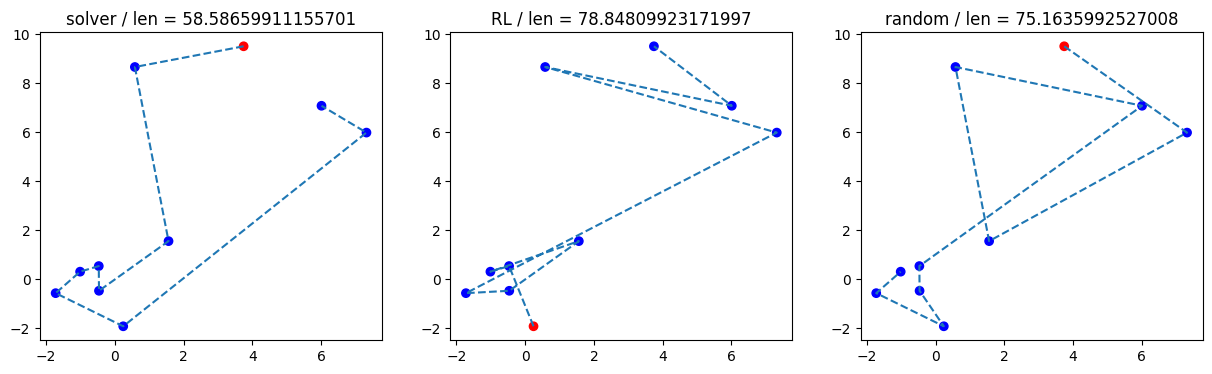

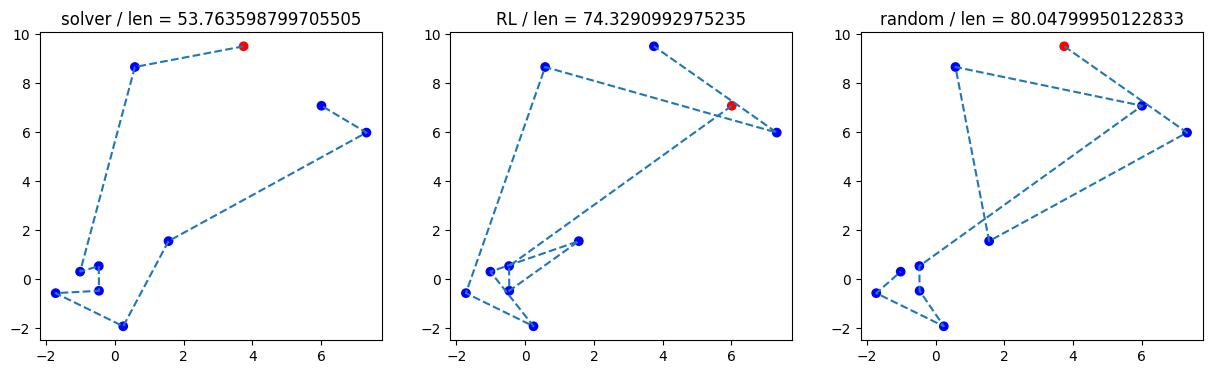

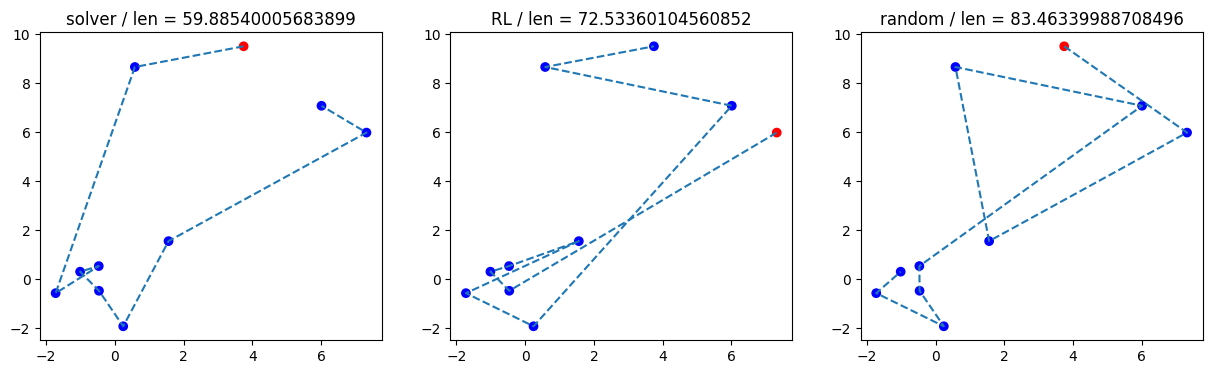

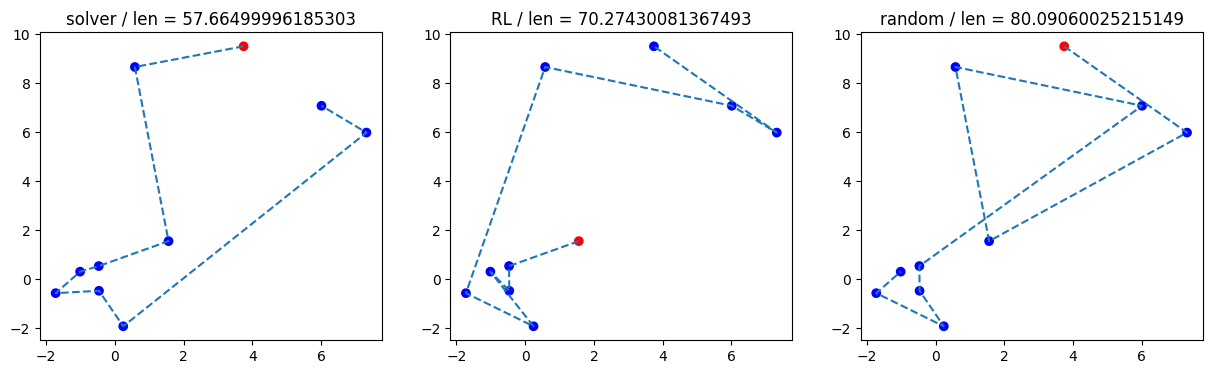

In [ ]:
""" Get file with smallest distance
"""
shortest_fname = get_best_model(model_type="maskEdge")

""" Load checkpoint
"""
Q_func, Q_net, optimizer, lr_scheduler = init_model(os.path.join(FOLDER_NAME, shortest_fname))



""" Generate example solutions
"""
#NR_NODES = 10
gap_rows=[]
for sample in range(5):
    coords = train_coords[sample]
    W_np = train_Ws[sample]
    W = torch.tensor(W_np, dtype=torch.float32, requires_grad=False, device=device)

    tru_tour = getTour(tru_optmodel, train_dataset_expert.sols[sample])
    tru_tour = tru_tour[:-1]

    solution = [random.randint(0, NR_NODES-1)]
    current_state = State(partial_solution=solution, W=W, coords=coords)
    current_state_tsr = state2tens(current_state)

    while not is_state_final(current_state):
        next_node, est_reward = Q_func.get_best_action(current_state_tsr,
                                                       current_state)


        solution = solution + [next_node]
        current_state = State(partial_solution=solution, W=W, coords=coords)
        current_state_tsr = state2tens(current_state)

    random_solution = list(range(NR_NODES))
    solutions = [tru_tour,solution,random_solution]
    obj_values = plot_solutions(coords, W, solutions)

    gap_rows.append( [ obj_values[1]/obj_values[0], obj_values[2]/obj_values[0], (obj_values[1]-obj_values[0]) / obj_values[0], (obj_values[2]-obj_values[0]) / obj_values[0]] )

gap_df = pd.DataFrame(data=gap_rows, columns=['RL_ratio', 'random_ratio', 'RL_gap', 'random_gap'])
display(gap_df)


## Completely remove the weights part from S2V aggregation

In [ ]:
class QNet_noEdge(nn.Module):
    """ The neural net that will parameterize the function Q(s, a)

        The input is the state (containing the graph and visited nodes),
        and the output is a vector of size N containing Q(s, a) for each of the N actions a.
    """

    def __init__(self, emb_dim, T=4):
        """ emb_dim: embedding dimension p
            T: number of iterations for the graph embedding
        """
        super(QNet_noEdge, self).__init__()
        self.emb_dim = emb_dim
        self.T = T

        # We use 5 dimensions for representing the nodes' states:
        # * A binary variable indicating whether the node has been visited
        # * A binary variable indicating whether the node is the first of the visited sequence
        # * A binary variable indicating whether the node is the last of the visited sequence
        # * The (x, y) coordinates of the node.
        #self.node_dim = 5
        self.node_dim = 10

        # We can have an extra layer after theta_1 (for the sake of example to make the network deeper)
        nr_extra_layers_1 = 1

        # Build the learnable affine maps:
        self.theta1 = nn.Linear(self.node_dim, self.emb_dim, True)
        self.theta2 = nn.Linear(self.emb_dim, self.emb_dim, True)
        self.theta3 = nn.Linear(self.emb_dim, self.emb_dim, True)
        self.theta4 = nn.Linear(1, self.emb_dim, True)
        self.theta5 = nn.Linear(2*self.emb_dim, 1, True)
        self.theta6 = nn.Linear(self.emb_dim, self.emb_dim, True)
        self.theta7 = nn.Linear(self.emb_dim, self.emb_dim, True)

        # Small note: your self.theta1_extras (line 35 in the QNet codeblock in the article) will not receive gradient updates when defined in this way.
        #self.theta1_extras = [nn.Linear(self.emb_dim, self.emb_dim, True) for _ in range(nr_extra_layers_1)]
        # Need to wrap in nn.ModuleList()
        self.theta1_extras = nn.ModuleList([nn.Linear(self.emb_dim, self.emb_dim, True) for _ in range(nr_extra_layers_1)])

    def forward(self, xv, Ws):
        # xv: The node features (batch_size, num_nodes, node_dim)
        # Ws: The graphs (batch_size, num_nodes, num_nodes)

        num_nodes = xv.shape[1]
        batch_size = xv.shape[0]

        # pre-compute 1-0 connection matrices masks (batch_size, num_nodes, num_nodes)
        # Eventhough we remove edge, this is still needed to link neighbours as N(v)
        conn_matrices = torch.where(Ws > 0, torch.ones_like(Ws), torch.zeros_like(Ws)).to(device)

        # Graph embedding
        # Note: we first compute s1 and s3 once, as they are not dependent on mu
        mu = torch.zeros(batch_size, num_nodes, self.emb_dim, device=device)

        s1 = self.theta1(xv)  # (batch_size, num_nodes, emb_dim)
        for layer in self.theta1_extras:
            s1 = layer(F.relu(s1))  # we apply the extra layer

        # Remove the 3rd term
        #s3_1 = F.relu(self.theta4(Ws.unsqueeze(3)))  # (batch_size, nr_nodes, nr_nodes, emb_dim) - each "weigth" is a p-dim vector
        #s3_2 = torch.sum(s3_1, dim=1)  # (batch_size, nr_nodes, emb_dim) - the embedding for each node
        #s3 = self.theta3(s3_2)  # (batch_size, nr_nodes, emb_dim)

        for t in range(self.T):
            s2 = self.theta2(conn_matrices.matmul(mu))
            #mu = F.relu(s1 + s2 + s3)
            mu = F.relu(s1 + s2 )

        """ prediction
        """
        # we repeat the global state (summed over nodes) for each node,
        # in order to concatenate it to local states later
        global_state = self.theta6(torch.sum(mu, dim=1, keepdim=True).repeat(1, num_nodes, 1))

        local_action = self.theta7(mu)  # (batch_dim, nr_nodes, emb_dim)

        out = F.relu(torch.cat([global_state, local_action], dim=2))
        return self.theta5(out).squeeze(dim=2)

In [ ]:
""" See what the model returns
"""
model = QNet_noEdge(3, T=1).to(device)
#coords, W_np = get_graph_mat(n=10)
n_coords, n_costs, n_coords, n_W_np = TSP10_genData(num_data=10)
coords=n_coords[0]
W_np=n_W_np[0]
W = torch.tensor(W_np, dtype=torch.float32, device=device)
#xv = torch.rand((1, W.shape[0], 5)).to(device) # random node state
xv = torch.rand((1, W.shape[0], 10)).to(device) # random node state
Ws = W.unsqueeze(0)

y = model(xv, Ws)
print('model output: {}'.format(y))

model output: tensor([[0.2044, 0.2044, 0.2044, 0.2044, 0.2044, 0.2044, 0.2044, 0.2044, 0.2044,
         0.2044]], device='cuda:0', grad_fn=<SqueezeBackward1>)


In [ ]:
def init_model_noedge(fname=None):
    """ Create a new model. If fname is defined, load the model from the specified file.
    """
    Q_net = QNet_noEdge(EMBEDDING_DIMENSIONS, T=EMBEDDING_ITERATIONS_T).to(device)
    optimizer = optim.Adam(Q_net.parameters(), lr=INIT_LR)
    lr_scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=LR_DECAY_RATE)

    if fname is not None:
        checkpoint = torch.load(fname)
        Q_net.load_state_dict(checkpoint['model'])
        optimizer.load_state_dict(checkpoint['optimizer'])
        lr_scheduler.load_state_dict(checkpoint['lr_scheduler'])

    Q_func = QFunction(Q_net, optimizer, lr_scheduler, fname)
    return Q_func, Q_net, optimizer, lr_scheduler

In [ ]:
#NR_EPISODES= 1000

# seed everything for reproducible results first:
torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

# Create module, optimizer, LR scheduler, and Q-function
Q_func, Q_net, optimizer, lr_scheduler = init_model_noedge()

# Create memory
memory = Memory(MEMORY_CAPACITY)

# Storing metrics about training:
found_solutions = dict()  # episode --> (coords, W, solution)
losses = []
path_lengths = []

# keep track of median path length for model checkpointing
current_min_med_length = float('inf')

for episode in range(NR_EPISODES):
    # sample a new random graph
    #coords, W_np = get_graph_mat(n=NR_NODES)
    coords = train_coords[episode]
    W_np = train_Ws[episode]

    W = torch.tensor(W_np, dtype=torch.float32, requires_grad=False, device=device)
    W_np_masked = (W_np > 0.0).astype(int)
    W_masked = torch.tensor(W_np_masked, dtype=torch.float32, requires_grad=False, device=device)

    # current partial solution - a list of node index
    # start at random node i
    solution = [random.randint(0, NR_NODES-1)]

    # current state (tuple and tensor)
    current_state = State(partial_solution=solution, W=W, coords=coords)
    current_state_tsr = state2tens(current_state)

    # Keep track of some variables for insertion in replay memory:
    states = [current_state]
    states_tsrs = [current_state_tsr]  # we also keep the state tensors here (for efficiency)
    rewards = []
    actions = []

    # current value of epsilon
    epsilon = max(MIN_EPSILON, (1-EPSILON_DECAY_RATE)**episode)

    nr_explores = 0
    t = -1
    while not is_state_final(current_state):
        t += 1  # time step of this episode

        if epsilon >= random.random():
            # explore
            next_node = get_next_neighbor_random(current_state)
            nr_explores += 1
        else:
            # exploit
            next_node, est_reward = Q_func.get_best_action(current_state_tsr, current_state)
            if episode % 50 == 0:
                print('Ep {} | current sol: {} / next est reward: {}'.format(episode, solution, est_reward))

        next_solution = solution + [next_node]

        # reward observed for taking this step
        reward = -(total_distance(next_solution, W) - total_distance(solution, W))

        next_state = State(partial_solution=next_solution, W=W_masked, coords=coords)
        next_state_tsr = state2tens(next_state)

        # store rewards and states obtained along this episode:
        states.append(next_state)
        states_tsrs.append(next_state_tsr)
        rewards.append(reward)
        actions.append(next_node)

        # store our experience in memory, using n-step Q-learning:
        if len(solution) >= N_STEP_QL:
            memory.remember(Experience(state=states[-N_STEP_QL],
                                       state_tsr=states_tsrs[-N_STEP_QL],
                                       action=actions[-N_STEP_QL],
                                       reward=sum(rewards[-N_STEP_QL:]),
                                       next_state=next_state,
                                       next_state_tsr=next_state_tsr))

        if is_state_final(next_state):
            for n in range(1, N_STEP_QL):
                memory.remember(Experience(state=states[-n],
                                           state_tsr=states_tsrs[-n],
                                           action=actions[-n],
                                           reward=sum(rewards[-n:]),
                                           next_state=next_state,
                                           next_state_tsr=next_state_tsr))

        # update state and current solution
        current_state = next_state
        current_state_tsr = next_state_tsr
        solution = next_solution

        # take a gradient step
        loss = None
        if len(memory) >= BATCH_SIZE and len(memory) >= 2000:
            experiences = memory.sample_batch(BATCH_SIZE)

            batch_states_tsrs = [e.state_tsr for e in experiences]
            batch_Ws = [e.state.W for e in experiences]
            batch_actions = [e.action for e in experiences]
            batch_targets = []

            for i, experience in enumerate(experiences):
                target = experience.reward
                if not is_state_final(experience.next_state):
                    _, best_reward = Q_func.get_best_action(experience.next_state_tsr,
                                                            experience.next_state)
                    target += GAMMA * best_reward
                batch_targets.append(target)

            # print('batch targets: {}'.format(batch_targets))
            loss = Q_func.batch_update(batch_states_tsrs, batch_Ws, batch_actions, batch_targets)
            losses.append(loss)

            """ Save model when we reach a new low average path length
            """
            med_length = np.median(path_lengths[-100:])
            if med_length < current_min_med_length:
                current_min_med_length = med_length
                checkpoint_model(Q_net, optimizer, lr_scheduler, loss, episode, med_length, model_type="noEdge")

    length = total_distance(solution, W)
    path_lengths.append(length)

    if episode % 10 == 0:
        print('Ep %d. Loss = %.3f / median length = %.3f / last = %.4f / epsilon = %.4f / lr = %.4f' % (
            episode, (-1 if loss is None else loss), np.median(path_lengths[-50:]), length, epsilon,
            Q_func.optimizer.param_groups[0]['lr']))
        found_solutions[episode] = (W.clone(), coords.copy(), [n for n in solution])

Ep 0. Loss = -1.000 / median length = 93.630 / last = 93.6301 / epsilon = 1.0000 / lr = 0.0050
Ep 10. Loss = -1.000 / median length = 93.630 / last = 98.0057 / epsilon = 0.9940 / lr = 0.0050
Ep 20. Loss = -1.000 / median length = 90.349 / last = 93.2648 / epsilon = 0.9881 / lr = 0.0050
Ep 30. Loss = -1.000 / median length = 90.992 / last = 81.6060 / epsilon = 0.9822 / lr = 0.0050
Ep 40. Loss = -1.000 / median length = 90.402 / last = 111.9045 / epsilon = 0.9763 / lr = 0.0050
Ep 50. Loss = -1.000 / median length = 91.243 / last = 93.4540 / epsilon = 0.9704 / lr = 0.0050
Ep 60. Loss = -1.000 / median length = 92.910 / last = 75.3903 / epsilon = 0.9646 / lr = 0.0050
Ep 70. Loss = -1.000 / median length = 94.094 / last = 100.5960 / epsilon = 0.9589 / lr = 0.0050
Ep 80. Loss = -1.000 / median length = 95.241 / last = 104.0699 / epsilon = 0.9531 / lr = 0.0050
Ep 90. Loss = -1.000 / median length = 98.012 / last = 104.8365 / epsilon = 0.9474 / lr = 0.0050
Ep 100 | current sol: [7, 2, 3, 6, 5]

In [ ]:
model_type="noEdge"
metrics_data[model_type]={}
metrics_data[model_type]["losses"] = losses
metrics_data[model_type]["path_lengths"] = path_lengths

### Plots

Text(0.5, 0, 'episode')

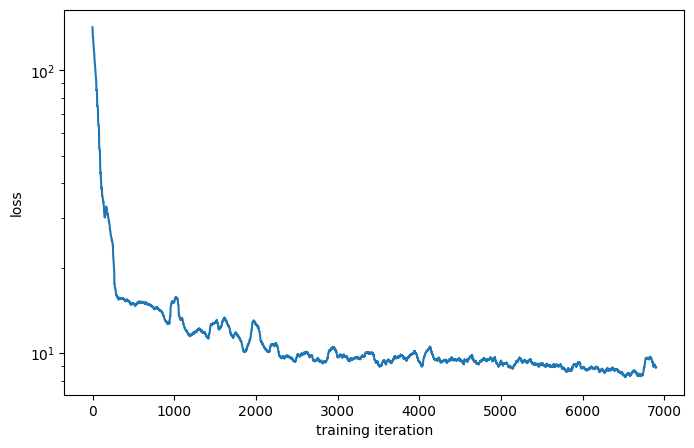

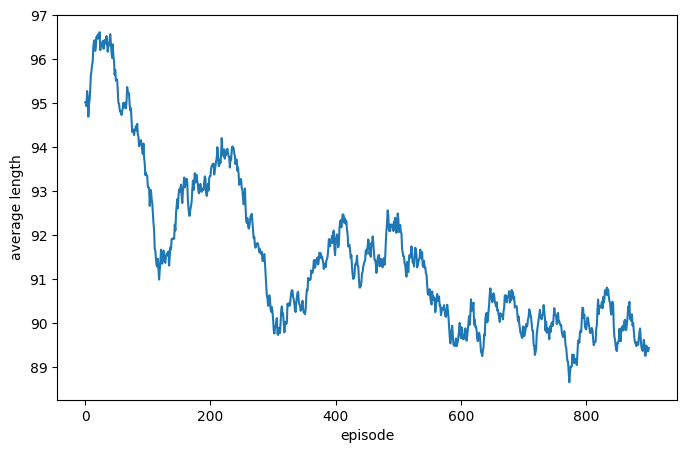

In [ ]:
# Plot training
plt.figure(figsize=(8,5))
plt.semilogy(_moving_avg(metrics_data[model_type]["losses"], 100))
plt.ylabel('loss')
plt.xlabel('training iteration')

plt.figure(figsize=(8,5))
plt.plot(_moving_avg(metrics_data[model_type]["path_lengths"], 100))
plt.ylabel('average length')
plt.xlabel('episode')

shortest avg length found: 87.32445019483566
best model: ep_818_length_87.32445019483566_type_noEdge.tar


,RL_ratio,random_ratio,RL_gap,random_gap
0,1.136297,1.352707,0.136297,0.352707
1,1.248772,1.282949,0.248772,0.282949
2,1.295665,1.488888,0.295665,0.488888
3,1.210166,1.393719,0.210166,0.393719
4,1.294194,1.388894,0.294194,0.388894


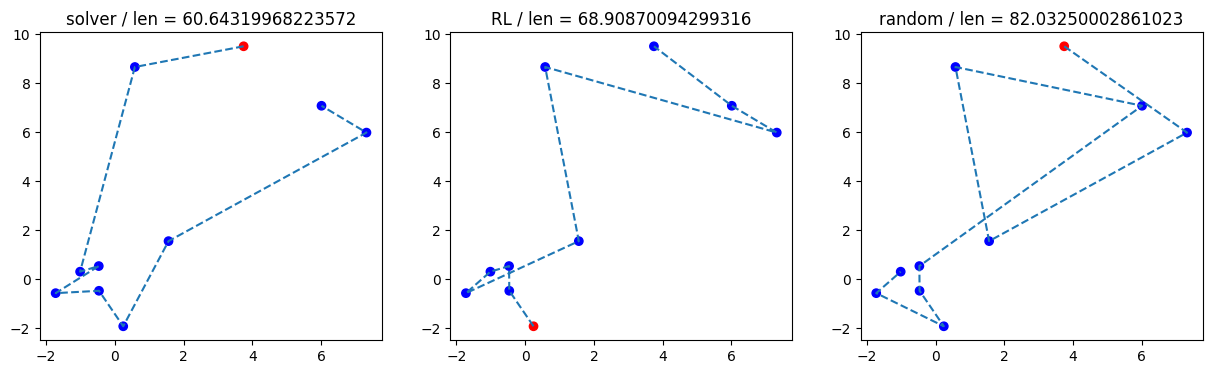

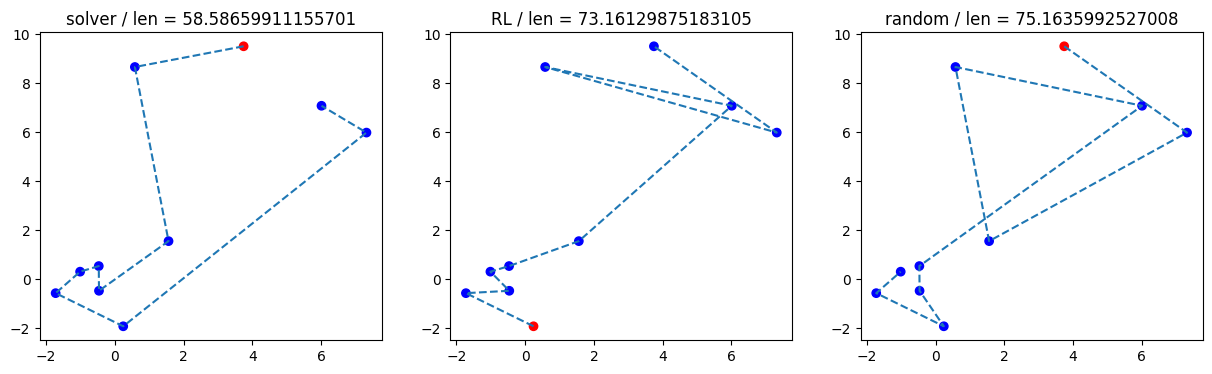

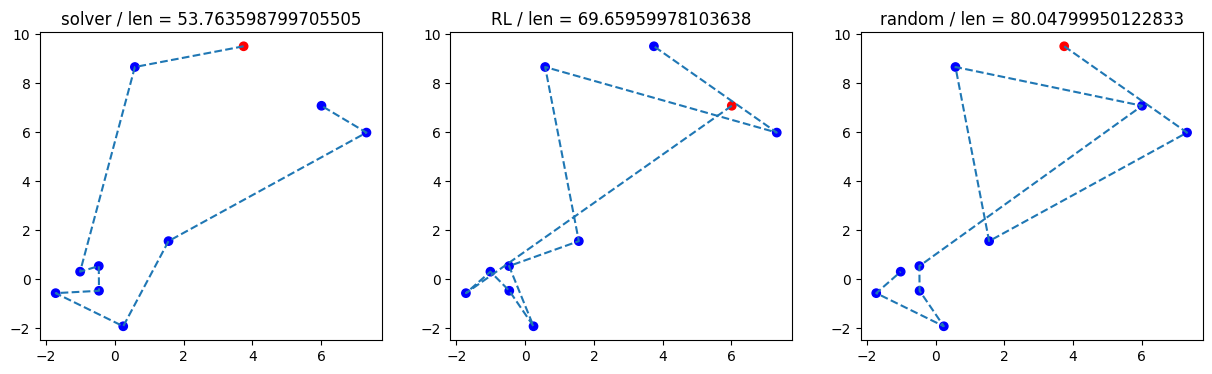

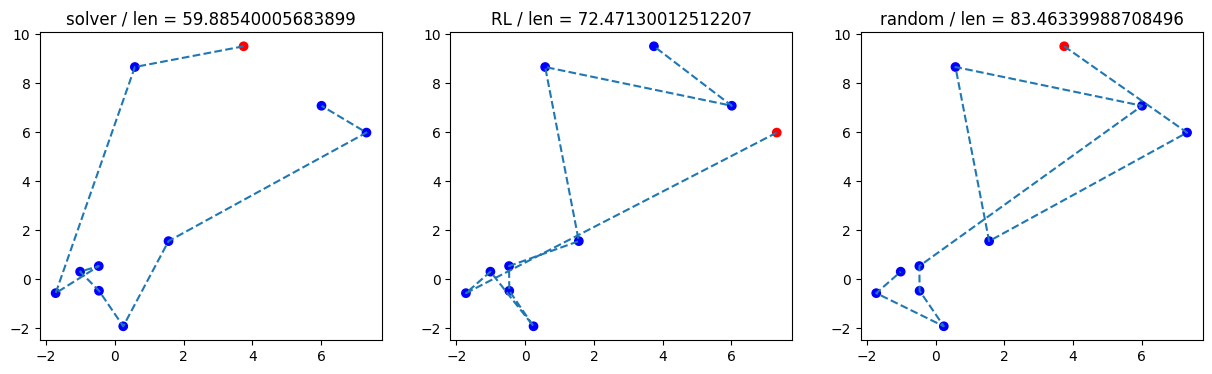

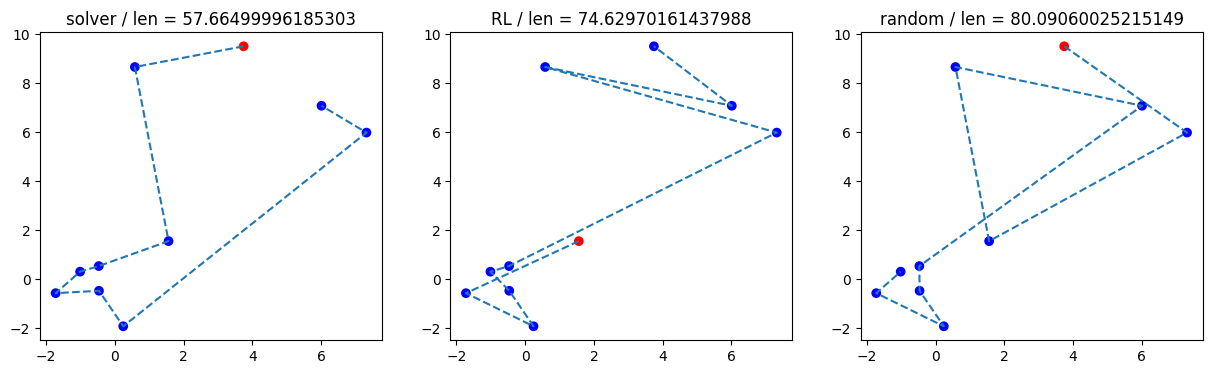

In [ ]:
""" Get file with smallest distance
"""
shortest_fname = get_best_model(model_type="noEdge")

""" Load checkpoint
"""
Q_func, Q_net, optimizer, lr_scheduler = init_model_noedge(os.path.join(FOLDER_NAME, shortest_fname))


""" Generate example solutions
"""
#NR_NODES = 10
gap_rows=[]
for sample in range(5):
    coords = train_coords[sample]
    W_np = train_Ws[sample]
    W = torch.tensor(W_np, dtype=torch.float32, requires_grad=False, device=device)

    tru_tour = getTour(tru_optmodel, train_dataset_expert.sols[sample])
    tru_tour = tru_tour[:-1]

    solution = [random.randint(0, NR_NODES-1)]
    current_state = State(partial_solution=solution, W=W, coords=coords)
    current_state_tsr = state2tens(current_state)

    while not is_state_final(current_state):
        next_node, est_reward = Q_func.get_best_action(current_state_tsr,
                                                       current_state)


        solution = solution + [next_node]
        current_state = State(partial_solution=solution, W=W, coords=coords)
        current_state_tsr = state2tens(current_state)

    random_solution = list(range(NR_NODES))
    solutions = [tru_tour,solution,random_solution]
    obj_values = plot_solutions(coords, W, solutions)

    gap_rows.append( [ obj_values[1]/obj_values[0], obj_values[2]/obj_values[0], (obj_values[1]-obj_values[0]) / obj_values[0], (obj_values[2]-obj_values[0]) / obj_values[0]] )

gap_df = pd.DataFrame(data=gap_rows, columns=['RL_ratio', 'random_ratio', 'RL_gap', 'random_gap'])
display(gap_df)


# Full plots



Text(0.5, 0.98, 'TSP10 - noise')

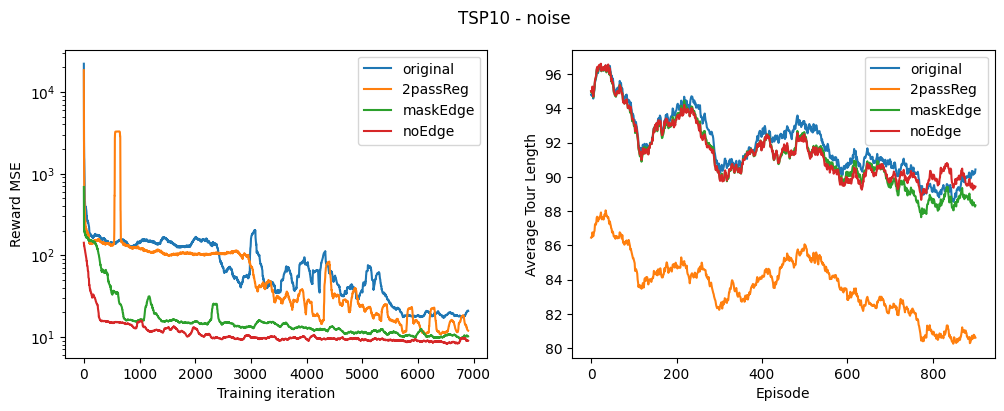

In [ ]:
def _moving_avg(x, N=10):
    return np.convolve(np.array(x), np.ones((N,))/N, mode='valid')

# Plot training
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,4))

model_types = ["original", "2passReg", "maskEdge", "noEdge"]
for model_type in model_types:
  #print(len(metrics_data[model_type]["losses"]))
  ax1.semilogy(_moving_avg(metrics_data[model_type]["losses"], 100),label=model_type)
  ax1.legend(loc="upper right")
  #print(len(metrics_data[model_type]["path_lengths"]))
  ax2.plot(_moving_avg(metrics_data[model_type]["path_lengths"], 100),label=model_type)
  ax2.legend(loc="upper right")

ax1.set_ylabel('Reward MSE')
ax1.set_xlabel('Training iteration')
ax2.set_ylabel('Average Tour Length')
ax2.set_xlabel('Episode')
plt.suptitle("TSP10 - noise")
#plt.legend()


# Training iteration = 7000
# Episodes = 1000
# Because we set Q-learning start if #memory > 2000, each episode have 9 steps, 9x1000 - 2000 = 7000

# Full comparisons

Over the pipelines

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
with open('TSP10_noise_metrics_data_1000_ep_1218.pkl', 'wb') as f:
    pickle.dump(metrics_data, f)

In [ ]:
!cp /content/TSP10_noise_metrics_data_1000_ep_1218.pkl /content/drive/MyDrive/MASc_MIE/Courses/MIE1666/Project/submit/data/TSP10_noise/

In [ ]:
!cp -r /content/TSP10_noise_models/ /content/drive/MyDrive/MASc_MIE/Courses/MIE1666/Project/submit/data/TSP10_noise/

In [ ]:
"""
!cp /content/drive/MyDrive/MASc_MIE/Courses/MIE1666/Project/data/TSP10_metrics_data_1000_ep_1201.pkl /content/

with open('TSP10_metrics_data_1000_ep_1201.pkl', 'rb') as handle:
    metrics_data = pickle.load(handle)
"""

In [ ]:
# Bigger test set
test_size=1000
feats=[]
costs=[]
test_coords=[]
test_Ws=[]

# Different seeds
np.random.seed(SEED+1)
torch.manual_seed(SEED+1)
random.seed(SEED+1)
"""
for sample in range(test_size):
    coords, W_np = get_graph_mat(n=NR_NODES)
    W = torch.tensor(W_np, dtype=torch.float32, requires_grad=False, device=device)

    features = coords.reshape(1,NR_NODES*2)
    tri_cost=dist_to_triangle(W_np)

    test_coords.append(coords)
    test_Ws.append(W_np)
    feats.append(features[0])
    costs.append(tri_cost)
"""
feats, costs, test_coords, test_Ws = TSP10_genData(num_data=NR_EPISODES, num_features=5, num_nodes=NR_NODES, deg=1, noise_width=0, seed=SEED+1)

print(np.array(feats).shape)
print(np.array(costs).shape)
print(np.array(test_coords).shape)
print(np.array(test_Ws).shape)

import pickle
test_set = [ feats, costs, test_coords, test_Ws ]
with open('TSP10_noise_test_set_1218.pkl', 'wb') as f:
    pickle.dump(test_set, f)


(1000, 25)
(1000, 45)
(1000, 10, 7)
(1000, 10, 10)


In [ ]:
!cp /content/TSP10_noise_test_set_1218.pkl /content/drive/MyDrive/MASc_MIE/Courses/MIE1666/Project/submit/data/TSP10_noise/
#!cp -r ./models /content/drive/MyDrive/MASc_MIE/Courses/MIE1666/Project/models/4000_epi_1130_models/

In [ ]:
"""
# Load back
!cp /content/drive/MyDrive/MASc_MIE/Courses/MIE1666/Project/data/TSP10_test_set_1201.pkl  /content/

with open('TSP10_test_set_1201.pkl', 'rb') as handle:
    test_set = pickle.load(handle)

[ feats, costs, test_coords, test_Ws ] = test_set
print(np.array(feats).shape)
print(np.array(costs).shape)
print(np.array(test_coords).shape)
print(np.array(test_Ws).shape)
"""

(1000, 20)
(1000, 45)
(1000, 10, 2)
(1000, 10, 10)


In [ ]:
model_types = ["original", "2passReg", "maskEdge", "noEdge"]
best_model_files = {}
best_models = {}
train_data = {}
for model_type in model_types:
  train_losses = metrics_data[model_type]["losses"]
  ave_losses = np.mean(train_losses)
  train_path_lengths = metrics_data[model_type]["path_lengths"]
  ave_path_lengths = np.mean(train_path_lengths)
  best_path_lengths = min(train_path_lengths)

  train_data[model_type]={"ave_loss": ave_losses, "ave_obj":ave_path_lengths, "best_obj":best_path_lengths, }

  best_model_files[model_type] = get_best_model(model_type=model_type)
  shortest_fname= best_model_files[model_type]

  if model_type == "noEdge":
    Q_func, _, _, _ = init_model_noedge(os.path.join(FOLDER_NAME, shortest_fname))
  else:
    Q_func, _, _, _ = init_model(os.path.join(FOLDER_NAME, shortest_fname))

  best_models[model_type]=Q_func

print(best_models['original'].name)
print(best_models['2passReg'].name)
#best_model_files

shortest avg length found: 86.17620021104813
best model: ep_873_length_86.17620021104813_type_original.tar
shortest avg length found: 78.64298105239868
best model: ep_877_length_78.64298105239868_type_2passReg.tar
shortest avg length found: 85.4273499250412
best model: ep_877_length_85.4273499250412_type_maskEdge.tar
shortest avg length found: 87.32445019483566
best model: ep_818_length_87.32445019483566_type_noEdge.tar
./TSP10_noise_models/ep_873_length_86.17620021104813_type_original.tar
./TSP10_noise_models/ep_877_length_78.64298105239868_type_2passReg.tar


In [ ]:
# Exact solver
test_dataset_expert = pyepo.data.dataset.optDataset(tru_optmodel, feats, costs)
#dataset_expert = pyepo.data.dataset.optDataset(tru_optmodel, feats[:10], costs[:10])
#test_size=10

# Gurobi Sovlver
# ~41s

Optimizing for optDataset...


100%|██████████| 1000/1000 [01:11<00:00, 14.00it/s]


In [ ]:
import pickle
test_dataset_expert_sols = [test_dataset_expert.sols, test_dataset_expert.objs]
with open('TSP10_test_noise_dataset_expert_sols.pkl', 'wb') as f:
    pickle.dump(test_dataset_expert_sols, f)

In [ ]:
!cp /content/TSP10_test_noise_dataset_expert_sols.pkl /content/drive/MyDrive/MASc_MIE/Courses/MIE1666/Project/submit/data/TSP10_noise/

In [ ]:
!cp /content/drive/MyDrive/MASc_MIE/Courses/MIE1666/Project/data/TSP10_test_dataset_expert_sols.pkl /content/

with open('TSP10_test_dataset_expert_sols.pkl', 'rb') as handle:
    test_dataset_expert_sols = pickle.load(handle)

#[test_dataset_expert.sols, test_dataset_expert.objs] = test_dataset_expert_sols

In [ ]:
# Set Seeds back
np.random.seed(SEED)
torch.manual_seed(SEED)
random.seed(SEED)

test_solutions=[]
test_object_values=[]
test_gap_rows=[]

for i in range(test_size):
#for i in range(5):
    tru_tour = getTour(tru_optmodel,test_dataset_expert.sols[i])
    tru_tour = tru_tour[:-1]

    # RL solution
    coords = test_coords[i]
    W_np = test_Ws[i]
    W = torch.tensor(W_np, dtype=torch.float32, requires_grad=False, device=device)


    RL_solutions = []
    for model_type in model_types:
      Q_func = best_models[model_type]
      #print(Q_func.name)
      solution = [random.randint(0, NR_NODES-1)]
      current_state = State(partial_solution=solution, W=W, coords=coords)
      current_state_tsr = state2tens(current_state)
      while not is_state_final(current_state):
          next_node, est_reward = Q_func.get_best_action(current_state_tsr,
                                                        current_state)


          solution = solution + [next_node]
          current_state = State(partial_solution=solution, W=W, coords=coords)
          current_state_tsr = state2tens(current_state)

      RL_solutions.append(solution)

    random_solution = list(range(NR_NODES))
    solutions = [tru_tour,random_solution,RL_solutions[0],RL_solutions[1],RL_solutions[2],RL_solutions[3]]
    test_solutions.append(solutions)

    obj_values = []
    for sol in solutions:
      obj_value = total_distance(sol, W)
      obj_values.append(obj_value)

    test_object_values.append(obj_values)


In [ ]:
test_gap_cols = ['exactSolver', 'random'] + model_types

test_gap_df = pd.DataFrame(data=test_object_values, columns=test_gap_cols)
test_gap_df_ratio = pd.concat([test_gap_df,test_gap_df.iloc[:,1:].div(test_gap_df.exactSolver, axis=0).add_suffix('_ratio')], axis=1)

display(test_gap_df_ratio)

,exactSolver,random,original,2passReg,maskEdge,noEdge,random_ratio,original_ratio,2passReg_ratio,maskEdge_ratio,noEdge_ratio
0,54.296400,71.536999,61.761799,61.397000,57.147500,66.728000,1.317527,1.137493,1.130775,1.052510,1.228958
1,56.785900,72.177300,61.284000,65.949700,65.949700,66.611401,1.271043,1.079212,1.161375,1.161375,1.173027
2,56.171600,66.947800,60.717700,67.311300,67.720200,63.079400,1.191844,1.080932,1.198316,1.205595,1.122977
3,59.350801,76.450201,72.288301,76.202800,67.115800,60.666501,1.288107,1.217984,1.283939,1.130832,1.022168
4,55.749600,77.255700,91.524100,79.937599,74.654900,64.735900,1.385762,1.641700,1.433869,1.339111,1.161190
...,...,...,...,...,...,...,...,...,...,...,...
995,60.114600,71.820200,66.313500,75.738101,67.878700,62.835700,1.194721,1.103118,1.259895,1.129155,1.045265
996,59.724499,75.678500,66.150899,76.041600,66.150899,62.746000,1.267127,1.107601,1.273206,1.107601,1.050591
997,52.418000,74.764500,67.066000,72.818100,67.228398,65.776000,1.426313,1.279446,1.389181,1.282544,1.254836
998,56.527800,81.167299,67.897000,86.669600,86.926800,70.833999,1.435883,1.201126,1.533221,1.537771,1.253083


In [ ]:
# Overview
# Train set
print("Train:")
for modl in train_data.items():
  print(modl[0])
  print(modl[1])

print("====================================")

# Test set
print("Test:")
display(test_gap_df_ratio.mean(axis=0))

# Runtime for each pipeline on 1000 testset is <10s

Train:
original
{'ave_loss': 397.56003142840314, 'ave_obj': 91.951812923491, 'best_obj': 63.42780065536499}
2passReg
{'ave_loss': 372.6179347700297, 'ave_obj': 83.56521942669153, 'best_obj': 56.49940204620361}
maskEdge
{'ave_loss': 29.200727001460447, 'ave_obj': 91.23348440366983, 'best_obj': 58.64380073547363}
noEdge
{'ave_loss': 13.060917191191445, 'ave_obj': 91.46293120980263, 'best_obj': 62.444000005722046}
Test:


exactSolver       56.878335
random            73.667661
original          68.785963
2passReg          73.152749
maskEdge          70.007124
noEdge            66.607088
random_ratio       1.296220
original_ratio     1.210320
2passReg_ratio     1.286145
maskEdge_ratio     1.231502
noEdge_ratio       1.172198
dtype: float64

In [ ]:
#test_gap_df_ratio
import pickle

with open('TSP10_test_noise_results_df.pkl', 'wb') as f:
    pickle.dump(test_gap_df_ratio, f)

!cp /content/TSP10_test_noise_results_df.pkl /content/drive/MyDrive/MASc_MIE/Courses/MIE1666/Project/submit/data/TSP10_noise/

# PyEPO Baselines

In [ ]:
#train_dataset_expert_sols[0]

NameError: ignored

In [ ]:
"""
import pyepo
from pyepo.model.opt import optModel
from collections import defaultdict

tru_optmodel = pyepo.model.grb.tsp.tspMTZModel(NR_NODES)
# Exact solver

train_dataset_expert = pyepo.data.dataset.optDataset(tru_optmodel, train_feats, train_costs)
test_dataset_expert = pyepo.data.dataset.optDataset(tru_optmodel, feats, costs)

"""

Auto-Sklearn cannot be imported.
Restricted license - for non-production use only - expires 2025-11-24
Optimizing for optDataset...


100%|██████████| 1000/1000 [00:42<00:00, 23.75it/s]


Optimizing for optDataset...


100%|██████████| 1000/1000 [00:38<00:00, 26.24it/s]


In [ ]:
# set data loader
from torch.utils.data import DataLoader
batch_size = 32

# Sample less, train 500, test 200
#loader_train = DataLoader(train_dataset_expert[:500], batch_size=batch_size, shuffle=True)
#loader_test = DataLoader(test_dataset_expert[:200], batch_size=batch_size, shuffle=False)

# Full sets
loader_train = DataLoader(train_dataset_expert, batch_size=batch_size, shuffle=True)
loader_test = DataLoader(test_dataset_expert, batch_size=batch_size, shuffle=False)

In [ ]:
from torch import nn

# build linear model
class LinearRegression(nn.Module):

    def __init__(self):
        super(LinearRegression, self).__init__()
        #self.linear = nn.Linear(num_feat, (grid[0]-1)*grid[1]+(grid[1]-1)*grid[0])
        self.linear = nn.Linear(NR_NODES*2+5, NR_NODES*(NR_NODES-1)//2 )

    def forward(self, x):
        out = self.linear(x)
        return out

import torch
# init model
reg = LinearRegression()


In [ ]:
import time

# train model
def trainModel(reg, loss_func, method_name, num_epochs=10, lr=1e-2):
#def trainModel(reg, loss_func, method_name, num_epochs=20, lr=1e-2):
    # set adam optimizer
    optimizer = torch.optim.Adam(reg.parameters(), lr=lr)
    # train mode
    reg.train()
    # init log
    loss_log = []
    loss_log_regret = [pyepo.metric.regret(reg, optmodel, loader_test)]
    # init elpased time
    elapsed = 0
    for epoch in range(num_epochs):
        # start timing
        tick = time.time()
        # load data
        for i, data in enumerate(loader_train):
            x, c, w, z = data
            # cuda
            if torch.cuda.is_available():
                x, c, w, z = x.cuda(), c.cuda(), w.cuda(), z.cuda()
            # forward pass
            cp = reg(x)
            if method_name == "spo+":
                loss = loss_func(cp, c, w, z)
            if method_name == "ptb" or method_name == "pfy" or method_name == "nce" or method_name == "cmap":
                loss = loss_func(cp, w)
            if method_name == "dbb" or method_name == "nid":
                loss = loss_func(cp, c, z)
            if method_name == "ltr":
                loss = loss_func(cp, c)
            # backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            # record time
            tock = time.time()
            elapsed += tock - tick
            # log
            loss_log.append(loss.item())
        regret = pyepo.metric.regret(reg, optmodel, loader_test)
        loss_log_regret.append(regret)
        print("Epoch {:2},  Loss: {:9.4f},  Regret: {:7.4f}%".format(epoch+1, loss.item(), regret*100))
    print("Total Elapsed Time: {:.2f} Sec.".format(elapsed))
    return loss_log, loss_log_regret

from matplotlib import pyplot as plt

def visLearningCurve(loss_log, loss_log_regret):
    # create figure and subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,4))

    # draw plot for training loss
    ax1.plot(loss_log, color="c", lw=1)
    ax1.tick_params(axis="both", which="major", labelsize=12)
    ax1.set_xlabel("Iters", fontsize=16)
    ax1.set_ylabel("Loss", fontsize=16)
    ax1.set_title("Learning Curve on Training Set", fontsize=16)

    # draw plot for regret on test
    ax2.plot(loss_log_regret, color="royalblue", ls="--", alpha=0.7, lw=1)
    ax2.set_xticks(range(0, len(loss_log_regret), 2))
    ax2.tick_params(axis="both", which="major", labelsize=12)
    #ax2.set_ylim(0, 0.5)
    ax2.set_xlabel("Epochs", fontsize=16)
    ax2.set_ylabel("Regret", fontsize=16)
    ax2.set_title("Learning Curve on Test Set", fontsize=16)

    plt.show()

## SPO+ and solver

In [ ]:
import torch
# init model
reg = LinearRegression()
# cuda
if torch.cuda.is_available():
    reg = reg.cuda()

optmodel = pyepo.model.grb.tsp.tspMTZModel(NR_NODES)

regret = pyepo.metric.regret(reg, optmodel, loader_test)

# init SPO+ loss
spop = pyepo.func.SPOPlus(optmodel, processes=2)

loss_log, loss_log_regret = trainModel(reg, loss_func=spop, method_name="spo+")

#~ 12min V100 high-ram colab.
# 27 min for 20 epoch

Num of cores: 2
Epoch  1,  Loss:    2.6420,  Regret: 29.8850%
Epoch  2,  Loss:    3.6221,  Regret: 28.9941%
Epoch  3,  Loss:    0.3841,  Regret: 28.2543%
Epoch  4,  Loss:    0.2363,  Regret: 28.1362%
Epoch  5,  Loss:    0.4191,  Regret: 27.6053%
Epoch  6,  Loss:    0.0361,  Regret: 27.4760%
Epoch  7,  Loss:    0.3388,  Regret: 27.5533%
Epoch  8,  Loss:    0.4527,  Regret: 27.7036%
Epoch  9,  Loss:    0.2200,  Regret: 27.6515%
Epoch 10,  Loss:    0.6236,  Regret: 27.9960%
Total Elapsed Time: 10807.29 Sec.


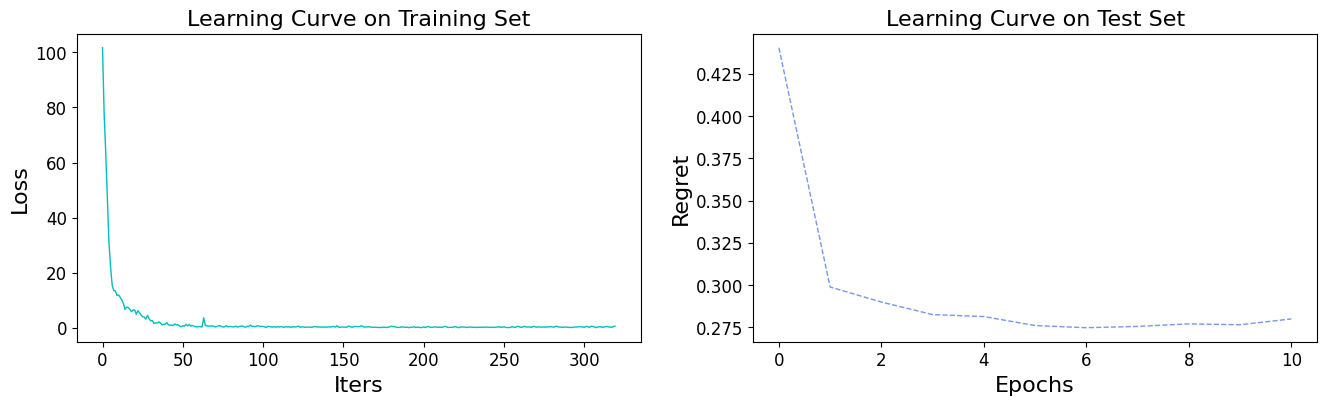

In [ ]:
visLearningCurve(loss_log, loss_log_regret)

## PFYL and solver

In [ ]:
import torch
# init model
reg = LinearRegression()
# cuda
if torch.cuda.is_available():
    reg = reg.cuda()

optmodel = pyepo.model.grb.tsp.tspMTZModel(NR_NODES)

# init pfyl loss
pfy = pyepo.func.perturbedFenchelYoung(optmodel, n_samples=3, sigma=1.0, processes=2)

pfy_loss_log, pfy_loss_log_regret = trainModel(reg, loss_func=pfy, method_name="pfy")

#~ 23min V100 high-ram colab.

Num of cores: 2
Epoch  1,  Loss:    3.1111,  Regret: 27.6835%
Epoch  2,  Loss:    4.1667,  Regret: 27.7894%
Epoch  3,  Loss:    2.3056,  Regret: 25.8077%
Epoch  4,  Loss:    2.8889,  Regret: 26.0523%
Epoch  5,  Loss:    2.6111,  Regret: 28.4632%
Epoch  6,  Loss:    2.8611,  Regret: 27.8397%
Epoch  7,  Loss:    1.3056,  Regret: 27.4653%
Epoch  8,  Loss:    2.1389,  Regret: 28.7077%
Epoch  9,  Loss:    2.3611,  Regret: 27.3382%
Epoch 10,  Loss:    1.6667,  Regret: 27.3759%
Total Elapsed Time: 9078.01 Sec.


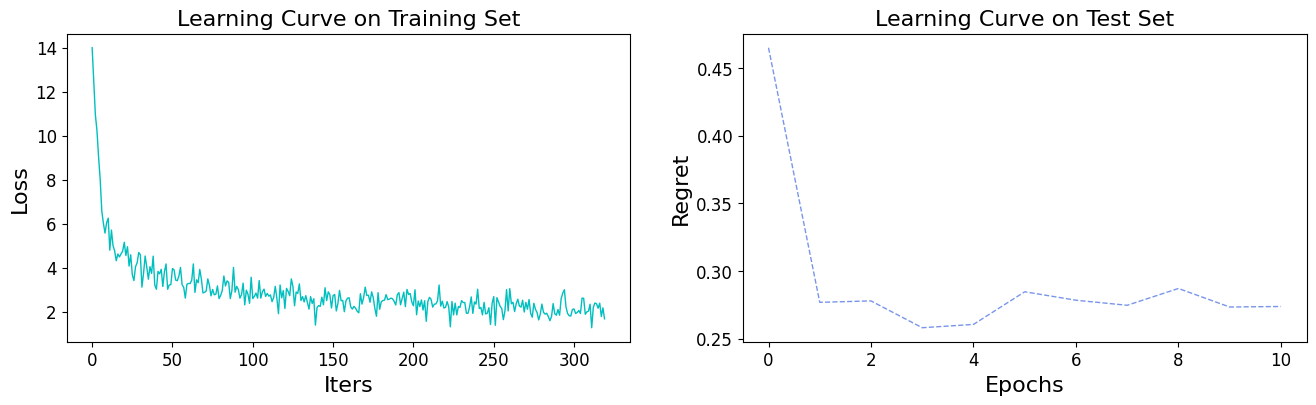

In [ ]:
visLearningCurve(pfy_loss_log, pfy_loss_log_regret)

## PFYL and OR-tools (heuristic)

In [ ]:
!pip install ortools

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.9/22.9 MB 43.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.2/130.2 kB 14.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 49.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.6/294.6 kB 30.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 341.8/341.8 kB 33.2 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 3.20.3
    Uninstalling protobuf-3.20.3:
      Successfully uninstalled protobuf-3.20.3
  Attempting uninstall: absl-py
    Found existing installation: absl-py 1.4.0
    Uninstalling absl-py-1.4.0:
      Successfully uninstalled absl-py-1.4.0
  Attempting uninstall: pandas
    Found existing installation: pandas 1.5.3
    Uninstalling pandas-1.5.3:
      Successfully uninstalled pandas-1.5.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behavi

#### Ensapsulate OR-tools as PyEPO model

In [ ]:
import sympy as sympy

import math
from ortools.constraint_solver import routing_enums_pb2
from ortools.constraint_solver import pywrapcp
import networkx as nx
#import numpy as np

class DictStruct:
    def __init__(self, **entries):
        self.__dict__.update(entries)

class tspORTOOLSModel(optModel):
    """
    This abstract class is optimization model for traveling salesman problem.
    This model is for further implementation of different formulation.

    Attributes:
        _model (GurobiPy model): Gurobi model
        num_nodes (int): Number of nodes
        edges (list): List of edge index
    """

    def __init__(self, num_nodes):
        """
        Args:
            num_nodes (int): number of nodes
        """
        self.num_nodes = num_nodes
        self.nodes = list(range(num_nodes))
        self.ORdata = None
        self.edges = [(i, j) for i in self.nodes
                      for j in self.nodes if i < j]

        #PyEPO/pkg/pyepo/EPO.py
        # min-objective
        # # sense
        # MINIMIZE = 1
        # MAXIMIZE = -1

        self.modelSense = 1
        super().__init__()

    def create_data_model_from_costs(self,c):
        """Stores the data for the problem."""
        data = {}
        """
        # Get num_nodes
        # This is a hack since in the PyEPO solver we only get the costs
        matrix_size = len(c)*2
        x = sympy.Symbol('x')
        ans_x = sympy.roots(x**2 - x - matrix_size, x)
        num_nodes,_ = list(ans_x.items())[0]
        """

        # https://stackoverflow.com/questions/70994759/or-tools-returning-solution-with-0-values
        # The ORTools solver is integral, and python silently rounds all distance value to 0.
        # You should scale everything by a constant factor (1000 for example)
        num_nodes = self.num_nodes

        distance_matrix = np.zeros((num_nodes,num_nodes))
        l=0
        # Expand c diagnally
        for j in range(num_nodes):
          for k in range(j + 1, num_nodes):
              distance_matrix[j][k] = round(c[l]*1000)
              l += 1

        distance_matrix = distance_matrix + distance_matrix.T - np.diag(np.diag(distance_matrix))

        # Also need to be integer here!
        data["distance_matrix"] = distance_matrix.astype(int).tolist()
        data["num_vehicles"] = 1
        data["depot"] = 0
        return data

    @property
    def num_cost(self):
        return len(self.edges)

    def copy(self):
        """
        A method to copy model

        Returns:
            optModel: new copied model
        """
        new_model = type(self)(self.num_nodes)
        return new_model

    def _getModel(self):
        """
        A method to build model

        Returns:
            tuple: optimization model and variables
        """
        # build graph as optimization model
        g = nx.Graph()
        """
        # Add position to nodes
        attrs_n = [(0, {'name': "zero", 'elev': 10}), \
           (1, {'name': "one", 'elev': 11})]
        nx.set_node_attributes(G, attrs_n)  # where nx is networkx
        """

        # add arcs as variables
        g.add_edges_from(self.edges, cost=0)
        return g, g.edges

    def setObj(self, c):
        """
        A method to set objective function

        Args:
            c (ndarray): cost of objective function
        """
        """
        for i, e in enumerate(self.edges):
            self._model.edges[e]["cost"] = c[i]
        """
        self.ORdata = self.create_data_model_from_costs(c)

    def tours_to_sol(self, tours):
        num_nodes=self.num_nodes
        edges=[]
        for i, j in enumerate(tours):
          if i<len(tours)-1:
            edges.append(sorted([j, tours[i+1]]))

        #print(edges)
        sol = np.zeros(num_nodes * (num_nodes - 1) // 2)
        l = 0
        for j in range(num_nodes):
            for k in range(j + 1, num_nodes):
                if [j,k] in edges:
                    sol[l]=1
                l += 1

        return sol

    def print_solution(self, manager, routing, solution):
        """Prints solution on console."""
        print(f"Objective: {solution.ObjectiveValue()} miles")
        index = routing.Start(0)
        plan_output = "Route for vehicle 0:\n"
        route_distance = 0
        while not routing.IsEnd(index):
            plan_output += f" {manager.IndexToNode(index)} ->"
            previous_index = index
            index = solution.Value(routing.NextVar(index))
            route_distance += routing.GetArcCostForVehicle(previous_index, index, 0)
        plan_output += f" {manager.IndexToNode(index)}\n"
        print(plan_output)
        plan_output += f"Route distance: {route_distance}miles\n"


    def get_routes(self, solution, routing, manager):
        """Get vehicle routes from a solution and store them in an array."""
        # Get vehicle routes and store them in a two dimensional array whose
        # i,j entry is the jth location visited by vehicle i along its route.
        routes = []
        for route_nbr in range(routing.vehicles()):
          index = routing.Start(route_nbr)
          route = [manager.IndexToNode(index)]
          while not routing.IsEnd(index):
            index = solution.Value(routing.NextVar(index))
            #print(index)
            route.append(manager.IndexToNode(index))
          routes.append(route)
        return routes

    def solve(self):
        """
        A method to solve model

        Returns:
            tuple: optimal solution (list) and objective value (float)
        """
        # ORTOOLS

        """Entry point of the program."""
        # Instantiate the data problem.
        #data = create_data_model()
        ORdata = self.ORdata

        # Create the routing index manager.
        manager = pywrapcp.RoutingIndexManager(
            len(ORdata["distance_matrix"]), ORdata["num_vehicles"], ORdata["depot"]
        )

        # Create Routing Model.
        routing = pywrapcp.RoutingModel(manager)

        def distance_callback(from_index, to_index):
            """Returns the distance between the two nodes."""
            # Convert from routing variable Index to distance matrix NodeIndex.
            from_node = manager.IndexToNode(from_index)
            to_node = manager.IndexToNode(to_index)
            return ORdata["distance_matrix"][from_node][to_node]
            #return self.ORdata["distance_matrix"][from_node][to_node]

        #print(distance_callback(0,4))
        # Define cost of each arc.
        transit_callback_index = routing.RegisterTransitCallback(distance_callback)

        # Define cost of each arc.
        routing.SetArcCostEvaluatorOfAllVehicles(transit_callback_index)

        # Setting first solution heuristic.
        search_parameters = pywrapcp.DefaultRoutingSearchParameters()
        search_parameters.local_search_metaheuristic = (
            routing_enums_pb2.LocalSearchMetaheuristic.AUTOMATIC)
            #routing_enums_pb2.LocalSearchMetaheuristic.GUIDED_LOCAL_SEARCH)
        #search_parameters.time_limit.seconds = 30
        #search_parameters.log_search = True
        search_parameters.time_limit.seconds = 3
        #search_parameters.log_search = False


        # Solve the problem.
        solution = routing.SolveWithParameters(search_parameters)

        # Print solution on console.
        if solution:
            #self.print_solution(manager, routing, solution)
            #print(routing)
            #print(solution.Value())
            routes = self.get_routes(solution, routing, manager)
            #print(routes[0][:-1])
            # For some reason ObjectiveValue is 0, I will ignore this for now since PFYL only needs solution.?
            # Fixed by forming everything to integer
            #print("solution.ObjectiveValue()", solution.ObjectiveValue())
            #sol = self.tours_to_sol(routes[0][:-1])
            sol = self.tours_to_sol(routes[0])
            obj = solution.ObjectiveValue() / 1000
        else:
            sol = np.zeros(self.num_nodes * (self.num_nodes - 1) // 2)
            obj = 0

        return sol, obj

# solvor model < heuristic model
# 1-step demo

#myoptmodel = tspORTOOLSModel(num_nodes=20)
myoptmodel = tspORTOOLSModel(num_nodes=NR_NODES)

myoptmodel.setObj(train_dataset_expert.costs[0]) # set objective function
sol, obj = myoptmodel.solve() # solve
#print(c[0])
print(np.array(myoptmodel.ORdata["distance_matrix"]))
print(sol)
print(obj)

heuristic_tour = getTour(myoptmodel,sol)
print(heuristic_tour)
print(len(heuristic_tour))

#ORdata = np.array(myoptmodel.ORdata["distance_matrix"])
#print(ORdata)

[[    0  8301 11300  6048  6320 12475 13992 14523 14459 14018]
 [ 8301     0 10298 10802  4049 12485 12926 13434 14169 13034]
 [11300 10298     0  9974 10113  5097  5879  6704  6930  6077]
 [ 6048 10802  9974     0  8635 11275 12158 13664 11706 10875]
 [ 6320  4049 10113  8635     0 12239 12951 13768 14048 12701]
 [12475 12485  5097 11275 12239     0  3698  5486  4423  3645]
 [13992 12926  5879 12158 12951  3698     0  4014  4268  3884]
 [14523 13434  6704 13664 13768  5486  4014     0  5902  5722]
 [14459 14169  6930 11706 14048  4423  4268  5902     0  4952]
 [14018 13034  6077 10875 12701  3645  3884  5722  4952     0]]
[0. 0. 1. 1. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 1. 1. 0. 0.]
60.91
[0, 3, 9, 6, 7, 8, 5, 2, 1, 4, 0]
11


In [ ]:
# get optDataset
heuristic_optmodel = tspORTOOLSModel(num_nodes=NR_NODES)

# get optDataset
heuristic_dataset_train = pyepo.data.dataset.optDataset(heuristic_optmodel, train_feats, train_costs)
heuristic_dataset_test = pyepo.data.dataset.optDataset(heuristic_optmodel, feats, costs)


# set data loader
#from torch.utils.data import DataLoader
#batch_size = 32

heuristic_loader_train = DataLoader(heuristic_dataset_train, batch_size=batch_size, shuffle=True)
heuristic_loader_test = DataLoader(heuristic_dataset_test, batch_size=batch_size, shuffle=False)

Optimizing for optDataset...


100%|██████████| 1000/1000 [00:02<00:00, 374.45it/s]


Optimizing for optDataset...


100%|██████████| 1000/1000 [00:02<00:00, 354.26it/s]


In [ ]:
# train model

def trainModel_heuristic(reg, loss_func, method_name, num_epochs=10, lr=1e-2):
    # set adam optimizer
    optimizer = torch.optim.Adam(reg.parameters(), lr=lr)
    # train mode
    reg.train()
    # init log
    loss_log = []
    loss_log_regret = [pyepo.metric.regret(reg, optmodel, heuristic_loader_test)]
    # init elpased time
    elapsed = 0
    for epoch in range(num_epochs):
        # start timing
        tick = time.time()
        # load data
        for i, data in enumerate(heuristic_loader_train):
            x, c, w, z = data
            # cuda
            if torch.cuda.is_available():
                x, c, w, z = x.cuda(), c.cuda(), w.cuda(), z.cuda()
            # forward pass
            cp = reg(x)
            if method_name == "spo+":
                loss = loss_func(cp, c, w, z)
            if method_name == "ptb" or method_name == "pfy" or method_name == "nce" or method_name == "cmap":
                loss = loss_func(cp, w)
            if method_name == "dbb" or method_name == "nid":
                loss = loss_func(cp, c, z)
            if method_name == "ltr":
                loss = loss_func(cp, c)
            # backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            # record time
            tock = time.time()
            elapsed += tock - tick
            # log
            loss_log.append(loss.item())
        regret = pyepo.metric.regret(reg, optmodel, heuristic_loader_test)
        loss_log_regret.append(regret)
        print("Epoch {:2},  Loss: {:9.4f},  Regret: {:7.4f}%".format(epoch+1, loss.item(), regret*100))
    print("Total Elapsed Time: {:.2f} Sec.".format(elapsed))
    return loss_log, loss_log_regret

Num of cores: 1
Epoch  1,  Loss:    5.7500,  Regret: 31.3281%
Epoch  2,  Loss:    5.0000,  Regret: 29.5079%
Epoch  3,  Loss:    7.0000,  Regret: 31.8584%
Epoch  4,  Loss:    5.5000,  Regret: 30.0087%
Epoch  5,  Loss:    5.5000,  Regret: 30.9452%
Epoch  6,  Loss:    2.5000,  Regret: 30.9897%
Epoch  7,  Loss:    6.7500,  Regret: 30.7896%
Epoch  8,  Loss:    5.2500,  Regret: 30.1796%
Epoch  9,  Loss:    3.7500,  Regret: 32.4116%
Epoch 10,  Loss:    4.2500,  Regret: 29.6233%
Total Elapsed Time: 6062.09 Sec.


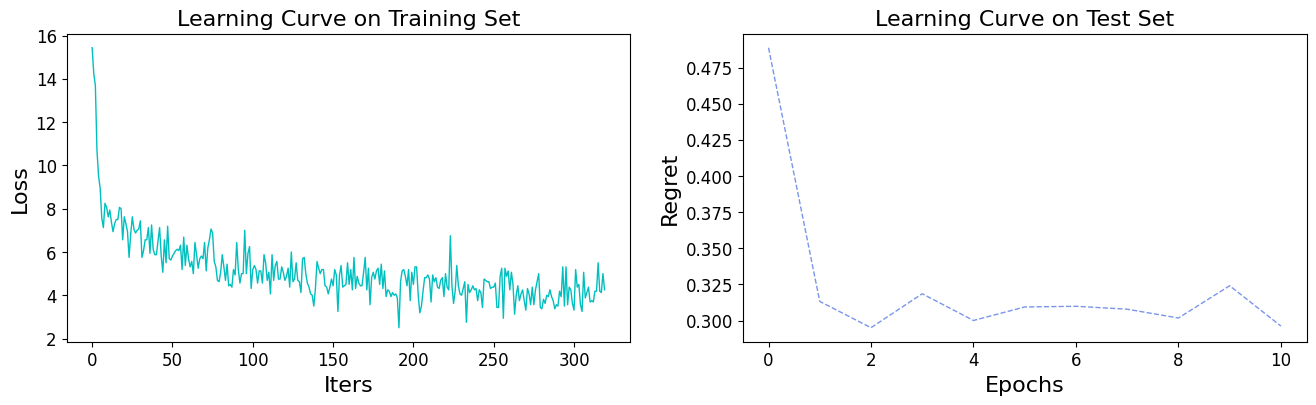

In [ ]:
# init model
reg = LinearRegression()
# cuda
if torch.cuda.is_available():
    reg = reg.cuda()

# init pfyl loss
# n_samples=6
# processes > 1 make weird learnings for some reason
pfy = pyepo.func.perturbedFenchelYoung(optmodel, n_samples=1, sigma=1.0, processes=1)

pfyOR_loss_log, pfyOR_loss_log_regret = trainModel_heuristic(reg, loss_func=pfy, method_name="pfy", num_epochs=10, lr=1e-2)

visLearningCurve(pfyOR_loss_log, pfyOR_loss_log_regret)

# ~15min

## SPO+ and OR-tools (heuristic)

In [ ]:
import torch
# init model
reg = LinearRegression()
# cuda
if torch.cuda.is_available():
    reg = reg.cuda()

optmodel = pyepo.model.grb.tsp.tspMTZModel(NR_NODES)

#regret = pyepo.metric.regret(reg, optmodel, loader_test)

# init SPO+ loss
spop = pyepo.func.SPOPlus(optmodel, processes=2)

spopOR_loss_log, spopOR_loss_log_regret = trainModel_heuristic(reg, loss_func=spop, method_name="spo+", num_epochs=10, lr=1e-2)

#~ 12min V100 high-ram colab.

Num of cores: 2
Epoch  1,  Loss:    2.0712,  Regret: 26.2081%
Epoch  2,  Loss:    0.7487,  Regret: 26.9647%
Epoch  3,  Loss:    0.2832,  Regret: 32.3273%
Epoch  4,  Loss:    1.4623,  Regret: 27.8577%
Epoch  5,  Loss:    0.3040,  Regret: 33.1837%
Epoch  6,  Loss:    0.4309,  Regret: 28.5308%
Epoch  7,  Loss:    0.2671,  Regret: 29.2661%
Epoch  8,  Loss:    1.4532,  Regret: 35.6297%
Epoch  9,  Loss:    0.7935,  Regret: 36.3493%
Epoch 10,  Loss:    0.6193,  Regret: 33.7669%
Total Elapsed Time: 17341.79 Sec.


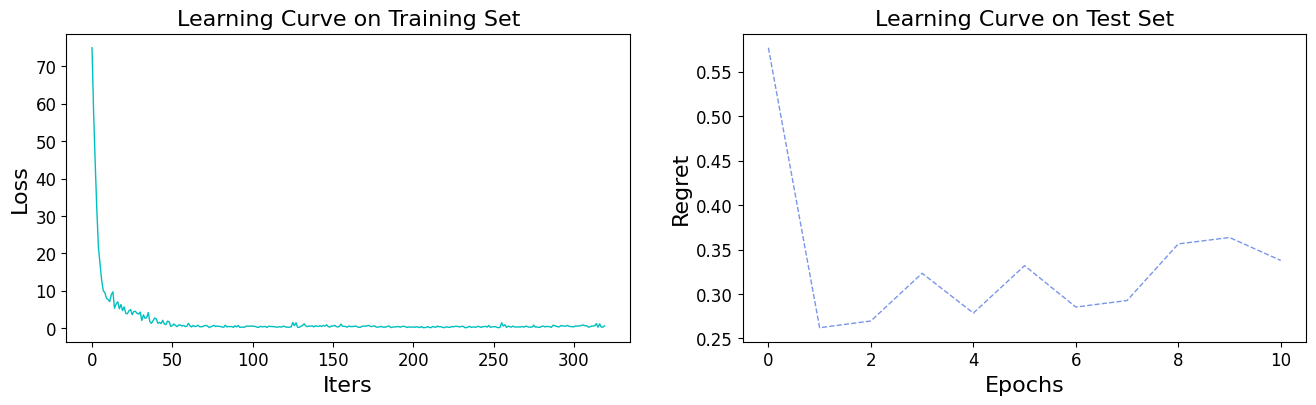

In [ ]:
visLearningCurve(spopOR_loss_log, spopOR_loss_log_regret)

In [ ]:
baseline_results= {}
baseline_results["SPO_sovler"]=(loss_log, loss_log_regret)
baseline_results["PFYL_sovler"]=(pfy_loss_log, pfy_loss_log_regret)
baseline_results["SPO_OR"]=(spopOR_loss_log, spopOR_loss_log_regret)
baseline_results["PFYL_OR"]=(pfyOR_loss_log, pfyOR_loss_log_regret)

# 20 epoch, lr=1e-2, TSP10
with open('TSP10_noise_baseline_results_1218.pkl', 'wb') as f:
    pickle.dump(baseline_results, f)


In [ ]:
!cp /content/TSP10_noise_baseline_results_1218.pkl /content/drive/MyDrive/MASc_MIE/Courses/MIE1666/Project/submit/data/TSP10_noise/

# Baseline results

In [ ]:
def print_baseline(baseline_results):
  for baseline in baseline_results:
    print(baseline)
    print("Average Cost:", np.mean(baseline_results[baseline][0]))
    print("Regret Loss:", np.min(baseline_results[baseline][1]))

print_baseline(baseline_results)

SPO_sovler
Average Cost: 2.036027343943715
Regret Loss: 0.2747597441011719
PFYL_sovler
Average Cost: 2.921636303514242
Regret Loss: 0.2580769578773656
SPO_OR
Average Cost: 1.7880480401217937
Regret Loss: 0.2620805295462382
PFYL_OR
Average Cost: 5.1189453125
Regret Loss: 0.2950787115292851
